In [1]:
import os
from pathlib import Path
from operator import itemgetter
import pickle
import pydicom
from time import time
import pandas

import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, LineString, GeometryCollection, Point, MultiPoint
from shapely.affinity import translate

from catch_converter.parse_contours import parse_cvi42ws
from LazyLuna.Mini_LL import *
from LazyLuna.CATCH_utils import *
from LazyLuna.Figures import *

In [2]:
# basepaths
bp        = '/Users/dietrichhadler/Desktop/Daten/LAX_Fett'
bp_annos1 = '/Users/dietrichhadler/Desktop/Daten/LAX_Fett/Edyta'
#bp_annos1 = '/Users/dietrichhadler/Desktop/Daten/LAX_Fett/AI'
bp_cases  = '/Users/dietrichhadler/Desktop/Daten/LAX_Fett/Cases'
bp_imgs   = '/Users/dietrichhadler/Desktop/Daten/LAX_Fett/Imgs'

In [ ]:
#parse_cvi42ws(bp_annos1, bp_annos1, process=True, debug=False)

In [ ]:
lax_cine_view = LAX_CINE_View()
cases = []

# get the paths of imgs and annotations via SeriesInstanceUIDs
#imgp, annop = [(p1,p2) for p1,p2 in get_imgs_and_annotation_paths(bp_imgs, bp_annos1) if case_name in p1][0]
paths = get_imgs_and_annotation_paths(bp_imgs, bp_annos1)
for imgp, annop in paths:
    #if not '1.3.12.2.1107.5.2.43.167071.30000021082405410237400000007' in annop: continue
    try:
        print(imgp, annop)
        st = time()
        case = Case(imgp, annop, os.path.basename(imgp), os.path.basename(bp_annos1))
        case = lax_cine_view.initialize_case(case)
        case.store(bp_cases)
        cases.append(case)
        print('Case customization took: ', time()-st, 'Case: ', case.reader_name, case.case_name)
    except Exception as e:
        print('Failed at: ', imgp, annop, ' , Exception: ', e)
    print()

In [3]:
cases = [pickle.load(open(os.path.join(bp_cases, p), 'rb')) for p in os.listdir(bp_cases)]
view  = LAX_CINE_View()
#cases = [view.customize_case(c) for c in cases if c.reader_name=='AI']
cases = [view.customize_case(c) for c in cases if c.reader_name=='Edyta']
print(len(cases))

12


In [ ]:
case = cases[0]
cats = case.categories
print([c for c in cats if 'LAX 4CV' in c.name])
cat = [c for c in cats if 'LAX 4CV' in c.name][0]
for p in range(cat.nr_phases):
    print(cat.get_anno(0,p).anno)

In [4]:
from tensorflow.keras.utils import Sequence
import imgaug
from imgaug.augmentables.batches import UnnormalizedBatch
from imgaug import augmenters as iaa

import math

# custom z score augmenter
def func_images(images, random_state, parents, hooks):
    return [(image-np.mean(image)) / np.std(image) for image in images]
def func_polygons(polygons_on_images, random_state, parents, hooks):
    return polygons_on_images
custom_zscore_augmenter = iaa.Lambda(func_images=func_images, func_polygons=func_polygons)

# order is important 
aug = iaa.Sequential([
    iaa.PadToFixedSize(width=360, height=360, position='center', pad_mode=["linear_ramp"]), #constant, edge, linear_ramp, maximum, median, minimum, reflect, symmetric, wrap
    iaa.Sometimes(0.6, iaa.Affine(rotate = (-180, 180), scale = {"x": (0.8, 1.2), "y": (0.8, 1.2)})),      # rotation and scaling performed quite often
    iaa.Fliplr(0.5),
    iaa.Sometimes(0.6, iaa.Affine(translate_percent={"x": (-0.07, 0.07), "y": (-0.07, 0.07)}, shear=(-5, 5))), # translation and shearing occurs, but not as often
    iaa.CropToFixedSize(width=192, height=192, position='center'),
    custom_zscore_augmenter,                                                  # a custom zscore is applied (see above) after cropping, otherwise the means/variances are distorted significantly
    iaa.Sometimes(0.15, iaa.AveragePooling(((1, 2), (1, 2)))),                # average pooling mimics a downsampling of the x or y axis
    iaa.Sometimes(0.25, iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.07))), # some noise, 0.2 definitely too high, 0.05 not visible, 0.07 looks good
    iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 1.5))),                    # weak blur and occasionally (1.5% of cases) strong blur
    iaa.Sometimes(0.25, iaa.Multiply((0.7, 1.3))),                             # brightness 
    iaa.Sometimes(0.25, iaa.LinearContrast((0.7, 1.4))),                      # contrast augmentation
], random_order=False)                                                        # apply augmenters in random order

# order is important 
no_aug = iaa.Sequential([
    iaa.PadToFixedSize( width=360, height=360, position='center', pad_mode=["linear_ramp"]), #constant, edge, linear_ramp, maximum, median, minimum, reflect, symmetric, wrap
    iaa.CropToFixedSize(width=192, height=192, position='center'),
    custom_zscore_augmenter,                                                  # a custom zscore is applied (see above) after cropping, 
], random_order=False)                                                        # apply augmenters in random order

In [16]:
class CatchGenerator(Sequence):
    def __init__(self, basepath, epochs_max, batch_size, k, k_max, provide_validation_set, aug, no_aug):
        self.basepath = basepath
        case_paths = [p for p in os.listdir(self.basepath) if p.endswith('.pickle')]
        self.cases = [pickle.load(open(os.path.join(basepath, fname), 'rb')) for fname in case_paths]
        self.cases = [c for c in self.cases if c.reader_name=='Edyta']
        print('Nr of cases: ', len(self.cases))
        lax_cine_view = Mini_LL.LAX_CINE_View()
        self.cases = [lax_cine_view.customize_case(case) for case in self.cases]
        self.tr_cases, self.val_cases = self.get_kcross_datasets(self.cases, k, k_max)
        self.epochs_max = epochs_max
        self.batch_size = batch_size
        self.aug        = aug
        self.no_aug     = no_aug
        self.k, self.k_max          = k, k_max
        self.provide_validation_set = provide_validation_set
        self.gen = self._multiprocessing_augmented_batches()
        
    def __len__(self):
        cases = self.val_cases if self.provide_validation_set else self.tr_cases
        return math.ceil(sum(2 for case in cases) / self.batch_size)
        
    def get_kcross_datasets(self, cases, k, k_max):
        n           = len(cases)
        k_nr        = n // k_max
        # HACKED FOR IDEATION STAGE ### TODO, correct ###
        train_cases = cases
        val_cases   = cases
        return train_cases, val_cases
    
    def _unaugmented_batch(self):
        scale = 1.0
        cases = self.val_cases if self.provide_validation_set else self.tr_cases
        imgs, polys = [], []
        for i in range(self.batch_size):
            case    = cases[np.random.randint(0, len(cases))]
            cats    = [c for c in case.categories if 'LAX 4CV' in c.name]
            cat     = cats[np.random.randint(0, len(cats))]
            d       = np.random.randint(0, cat.nr_slices)
            p       = cat.get_phase()
            img     = cat.get_img(d, p).astype(np.float32)
            h, w    = img.shape
            #img     = cv2.resize(img, (int(np.round(w*scale)), int(np.round(h*scale))), interpolation=cv2.INTER_CUBIC)
            anno    = cat.get_anno(d, p)
            lv_ext  = anno.get_point('lv_lax_extent')     if anno.has_point('lv_lax_extent')     else None
            ra_ext  = anno.get_point('laxRaExtentPoints') if anno.has_point('laxRaExtentPoints') else None
            la_ext  = anno.get_point('laxLaExtentPoints') if anno.has_point('laxLaExtentPoints') else None
            
            if anno.has_point('lv_lax_extent'): 
                lv_ext1 = lv_ext[0].buffer(5.0).simplify(0.01, preserve_topology=True).exterior.coords
                lv_ext2 = lv_ext[1].buffer(5.0).simplify(0.01, preserve_topology=True).exterior.coords
                lv_ext3 = lv_ext[2].buffer(5.0).simplify(0.01, preserve_topology=True).exterior.coords
                lv_ext1 = imgaug.augmentables.polys.Polygon(np.array(lv_ext1), 'lv_ext1')
                lv_ext2 = imgaug.augmentables.polys.Polygon(np.array(lv_ext2), 'lv_ext2')
                lv_ext3 = imgaug.augmentables.polys.Polygon(np.array(lv_ext3), 'lv_ext3')
            
            if anno.has_point('laxRaExtentPoints'):
                ra_ext1 = ra_ext[0].buffer(5.0).simplify(0.01, preserve_topology=True).exterior.coords
                ra_ext2 = ra_ext[1].buffer(5.0).simplify(0.01, preserve_topology=True).exterior.coords
                ra_ext3 = ra_ext[2].buffer(5.0).simplify(0.01, preserve_topology=True).exterior.coords
                ra_ext1 = imgaug.augmentables.polys.Polygon(np.array(ra_ext1), 'ra_ext1')
                ra_ext2 = imgaug.augmentables.polys.Polygon(np.array(ra_ext2), 'ra_ext2')
                ra_ext3 = imgaug.augmentables.polys.Polygon(np.array(ra_ext3), 'ra_ext3')
            
            if anno.has_point('laxLaExtentPoints'):
                la_ext1 = la_ext[0].buffer(5.0).simplify(0.01, preserve_topology=True).exterior.coords
                la_ext2 = la_ext[1].buffer(5.0).simplify(0.01, preserve_topology=True).exterior.coords
                la_ext3 = la_ext[2].buffer(5.0).simplify(0.01, preserve_topology=True).exterior.coords
                la_ext1 = imgaug.augmentables.polys.Polygon(np.array(la_ext1), 'la_ext1')
                la_ext2 = imgaug.augmentables.polys.Polygon(np.array(la_ext2), 'la_ext2')
                la_ext3 = imgaug.augmentables.polys.Polygon(np.array(la_ext3), 'la_ext3')
            
            poly    = [c for c in [lv_ext1, lv_ext2, lv_ext3, ra_ext1, ra_ext2, ra_ext3, la_ext1, la_ext2, la_ext3] if c]
            imgs.append(img); polys.append(poly)
        return imgs, polys
    
    def _make_unaugmented_batch(self, imgs, polys):
        batch = UnnormalizedBatch(images=imgs, polygons=polys)
        return batch
    
    def _unaugmented_batch_generator(self):
        for i in range(len(self)+1):
            imgs, polys = self._unaugmented_batch()
            batch = self._make_unaugmented_batch(imgs, polys)
            yield batch
            
    def _multiprocessing_augmented_batches(self):
        unaug  = self._unaugmented_batch_generator()
        for i, batch in enumerate(unaug):
            imgs1  = batch.images_unaug
            polys1 = batch.polygons_unaug
            batches_aug = list(self.aug.augment_batches(batch, background=False))  # list() converts generator to list
            imgs        = batches_aug[0].images_aug
            polys       = batches_aug[0].polygons_aug
            img_batch, mask_batch = [], []
            for j in range(batch_size):
                img, poly = imgs[j], polys[j]
                h, w = img.shape
                mask = np.zeros((h, w, 9))
                for k in range(len(poly)):
                    mask[:,:,k] = CATCH_utils.to_mask(poly[k].to_shapely_polygon(), h, w)
                    mask[:,:,k] = cv2.GaussianBlur(mask[:,:,k],(5,5),cv2.BORDER_CONSTANT)
                img_batch .append(img)
                mask_batch.append(mask)
            yield img_batch, mask_batch
    
    def __getitem__(self, index):
        img_batch, mask_batch = next(self.gen)
        return (np.asarray(img_batch), np.asarray(mask_batch))
        
    def on_epoch_end(self):
        self.gen = self._multiprocessing_augmented_batches()        

In [ ]:
lax_cine_view = LAX_CINE_View()
for case in cases:
    print(case.categories)
    print(case.case_name)
    print('Clinical Results')
    case = lax_cine_view.customize_case(case)
    #for cr in case.crs:
    #    print(cr.name)
    #    print(cr.name, cr.get_cr(string=True), cr.unit)

    cats = ['LAX 4CV LVES', 'LAX 4CV LVED']
    for cat in case.categories:
        if cat.name in cats:
            print(cat.name)
            #for p in range(cat.nr_phases):
            fig, ax = plt.subplots(1,1,figsize=(9,9))
            img  = cat.get_img (0, cat.phase)
            anno = cat.get_anno(0, cat.phase)
            ax.imshow(img, cmap='gray')#; ax.axis('off')
            anno.plot_all_contour_outlines(ax)
            plt.show()
    print()

In [17]:
img_h, img_w, img_c, out_c = 128, 128, 1, 5
d, st_ch, dr = 5, 16, 0.1

#bp = '/media/omega/Daten1/CATCH/CS/Cases'
bp  = '/Users/dietrichhadler/Desktop/Daten/LAX_Fett/Cases'

epochs_max = 3
batch_size = 16
k = 0
k_max = 5
provide_validation_set = False

gen = CatchGenerator(bp_cases, epochs_max, batch_size, k, k_max, 
                     provide_validation_set, aug, no_aug)

Nr of cases:  12


<ipython-input-16-fb99a7a2ee6b>:50: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  lv_ext1 = lv_ext[0].buffer(5.0).simplify(0.01, preserve_topology=True).exterior.coords
<ipython-input-16-fb99a7a2ee6b>:51: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  lv_ext2 = lv_ext[1].buffer(5.0).simplify(0.01, preserve_topology=True).exterior.coords
<ipython-input-16-fb99a7a2ee6b>:52: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  lv_ext3 = lv_ext[2].buffer(5.0).simplify(0.01, preserve_topology=True).exterior.coords
<ipython-input-16-fb99a7a2ee6b>

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.4140625  0.5546875  0.56640625 0.5703125  0.62890625 0.6328125
 0.6640625  0.6875     0.7421875  0.82421875 0.8359375  0.85546875
 0.859375   0.921875   0.9375     0.94140625 0.96484375 0.98046875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.55078125 0.5546875  0.5703125  0.62890625 0.640625   0.6640625
 0.6875     0.7265625  0.7421875  0.81640625 0.8359375  0.83984375
 0.859375   0.90625    0.91796875 0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375 

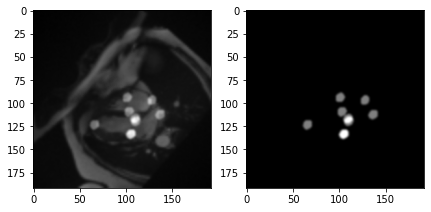

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.07421875 0.12109375 0.13671875
 0.140625   0.14453125 0.21875    0.23046875 0.234375   0.25390625
 0.28125    0.296875   0.3125     0.3203125  0.33203125 0.34765625
 0.4140625  0.4296875  0.546875   0.55078125 0.5546875  0.5703125
 0.62890625 0.640625   0.6640625  0.6796875  0.6875     0.7421875
 0.765625   0.81640625 0.8359375  0.83984375 0.84375    0.859375
 0.90625    0.921875   0.92578125 0.9375     0.94140625 0.95703125
 0.96484375 0.9765625  0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6328125  0.640625   0.6640625  0.6875
 0.7421875  0.8203125  0.8359375  0.83984375 0.85546875 0.859375
 0.90

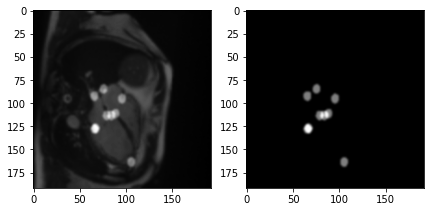

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.07421875 0.09765625 0.12109375
 0.125      0.13671875 0.14453125 0.15625    0.23046875 0.234375
 0.23828125 0.25390625 0.296875   0.3125     0.3203125  0.33203125
 0.34765625 0.36328125 0.40625    0.41015625 0.4140625  0.453125
 0.50390625 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.6328125  0.6640625  0.6796875  0.6875     0.7265625  0.7421875
 0.75       0.78125    0.8203125  0.8359375  0.85546875 0.859375
 0.91796875 0.921875   0.92578125 0.9375     0.94140625 0.953125
 0.9609375  0.96484375 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.07421875 0.09765625 0.12109375
 0.125      0.13671875 0.14453125 0.15625    0.23046875 0.234375
 0.23828125 0.25390625 0.2578125  0.296875   0.3125     0.3203125
 0.34765625 0.390625   0.40625    0.41015625 0.4140625  0.453125
 0.50390625 0.55468

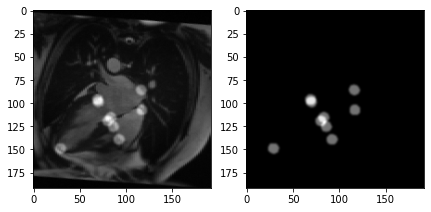

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.07421875 0.12109375 0.13671875 0.140625
 0.14453125 0.21875    0.23046875 0.25390625 0.296875   0.3125
 0.3203125  0.34765625 0.4140625  0.4296875  0.546875   0.5546875
 0.5703125  0.62890625 0.6640625  0.6796875  0.6875     0.7421875
 0.765625   0.8359375  0.83984375 0.84375    0.921875   0.92578125
 0.9375     0.94140625 0.95703125 0.96484375 0.9765625  0.99609375
 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.07421875 0.09765625 0.12109375
 0.125      0.13671875 0.14453125 0.15625    0.23046875 0.234375
 0.23828125 0.25390625 0.296875   0.3125     0.3203125  0.33203125
 0.34765625 0.40625    0.41015625 0.4140625  0.453125   0.50390625
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.6640625
 0.6796875  0.6875     0.7265625  0.7421875  0.75       0.78125
 0.8203125  0.8359375  0.83984375 0.859375   0.91796875 0.92187

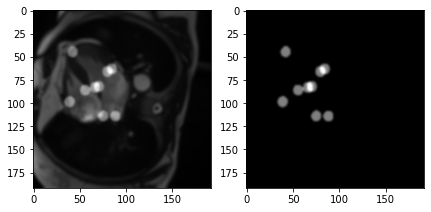

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.4140625
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.6640625
 0.6875     0.7421875  0.8203125  0.8359375  0.859375   0.921875
 0.9375     0.94140625 0.96484375 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21484375 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.296875   0.3125     0.33203125 0.34765625 0.36328125 0.41015625
 0.4140625  0.50390625 0.53125    0.546875   0.55078125 0.5546875
 0.56640625 0.5703125  0.6328125  0.6640625  0.6875     0.7265625
 0.7421875  0.8203125  0.8359375  0.84375    0.85546875 0.859375
 0.91796875 0.921875   0.9375     0.94140625 0.9609375  0.96484375
 0.9765625  0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.

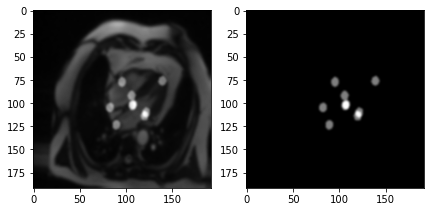

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.07421875 0.12109375 0.13671875 0.140625
 0.14453125 0.23046875 0.234375   0.25390625 0.28125    0.296875
 0.3125     0.3203125  0.33203125 0.34765625 0.4140625  0.4296875
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.640625
 0.6640625  0.6796875  0.6875     0.7421875  0.765625   0.81640625
 0.8203125  0.8359375  0.859375   0.90625    0.921875   0.92578125
 0.9375     0.94140625 0.95703125 0.96484375 0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.12109375 0.13671875 0.14453125
 0.21484375 0.21875    0.23046875 0.234375   0.25390625 0.28125
 0.296875   0.3125     0.33203125 0.34765625 0.36328125 0.4140625
 0.53125    0.546875   0.5546875  0.56640625 0.5703125  0.62890625
 0.6328125  0.640625   0.6640625  0.6875     0.7421875  0.8203125
 0.82421875 0.8359375  0.83984375 0.84375    0.85546

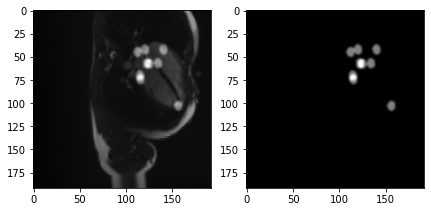

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.07421875 0.12109375 0.13671875 0.140625
 0.14453125 0.21875    0.23046875 0.25390625 0.296875   0.3125
 0.3203125  0.34765625 0.4140625  0.4296875  0.546875   0.5546875
 0.5703125  0.62890625 0.6640625  0.6796875  0.6875     0.7421875
 0.765625   0.8359375  0.83984375 0.84375    0.921875   0.92578125
 0.9375     0.94140625 0.95703125 0.96484375 0.9765625  0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.23046875
 0.234375   0.23828125 0.25390625 0.28125    0.296875   0.3125
 0.33203125 0.41015625 0.4140625  0.50390625 0.55078125 0.56640625
 0.5703125  0.640625   0.6640625  0.6875     0.7265625  0.7421875
 0.8203125  0.82421875 0.859375   0.90625    0.91796875 0.921875
 0.9375     0.94140625 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.054687

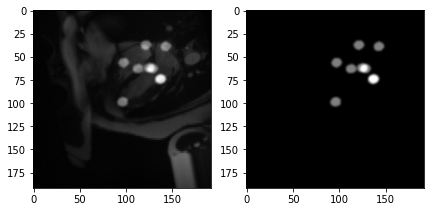

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.4140625  0.546875   0.55078125
 0.5546875  0.56640625 0.5703125  0.62890625 0.640625   0.6640625
 0.6875     0.7421875  0.8203125  0.82421875 0.8359375  0.83984375
 0.84375    0.859375   0.90625    0.921875   0.9375     0.94140625
 0.96484375 0.9765625  0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.05859375 0.0625     0.07421875 0.12109375
 0.125      0.13671875 0.14453125 0.15625    0.21875    0.23046875
 0.234375   0.25390625 0.296875   0.3125     0.3203125  0.33203125
 0.34765625 0.40625    0.4140625  0.453125   0.546875   0.55078125
 0.5546875  0.56640625 0.5703125  0.62890625 0.6640625  0.6796875
 0.6875     0.7421875  0.75       0.78125    0.8203125  0.8242187

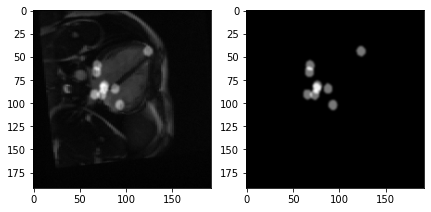

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.07421875 0.12109375 0.13671875
 0.140625   0.14453125 0.21875    0.23046875 0.25390625 0.28125
 0.296875   0.3125     0.3203125  0.33203125 0.34765625 0.36328125
 0.4140625  0.4296875  0.546875   0.55078125 0.5546875  0.5703125
 0.6328125  0.640625   0.6640625  0.6796875  0.6875     0.7421875
 0.765625   0.81640625 0.8359375  0.83984375 0.84375    0.85546875
 0.90625    0.921875   0.92578125 0.9375     0.94140625 0.95703125
 0.96484375 0.9765625  0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6328125  0.640625   0.6640625  0.6875
 0.7421875  0.8203125  0.8359375  0.85546875 0.859375   0.90625
 0.921875   0.9375

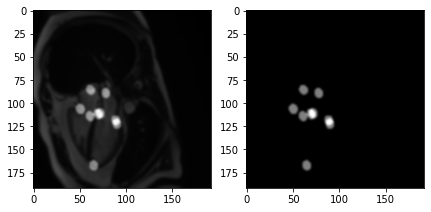

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21484375
 0.21875    0.23046875 0.25390625 0.296875   0.3125     0.34765625
 0.36328125 0.4140625  0.53125    0.546875   0.5546875  0.5703125
 0.62890625 0.6328125  0.6640625  0.6875     0.7421875  0.8203125
 0.8359375  0.83984375 0.84375    0.85546875 0.921875   0.9375
 0.94140625 0.9609375  0.96484375 0.9765625  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.56640625
 0.5703125  0.6328125  0.640625   0.6640625  0.6875     0.7421875
 0.8203125  0.8359375  0.85546875 0.859375   0.90625    0.921875
 0.9375     0.94140625 0.96484375 0.98046875 0.9921875  0.99609375
 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.

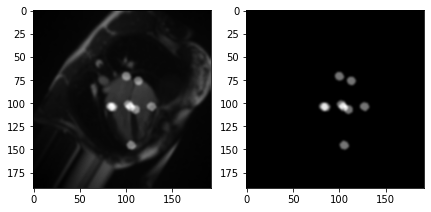

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.12109375 0.13671875 0.14453125
 0.15625    0.23046875 0.234375   0.25390625 0.296875   0.3125
 0.33203125 0.34765625 0.390625   0.4140625  0.453125   0.55078125
 0.5546875  0.56640625 0.5703125  0.62890625 0.6640625  0.6875
 0.7265625  0.7421875  0.78125    0.8203125  0.82421875 0.8359375
 0.859375   0.921875   0.9375     0.94140625 0.9609375  0.96484375
 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.0546875  0.05859375 0.07421875 0.12109375
 0.125      0.13671875 0.14453125 0.15625    0.21484375 0.21875
 0.23046875 0.234375   0.25390625 0.28125    0.296875   0.3203125
 0.33203125 0.34765625 0.390625   0.40625    0.4140625  0.453125
 0.53125    0.546875   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.640625   0.6640625  0.6796875  0.7265625  0.7421875
 0.75       0.78125    0.8203125  0.82421875

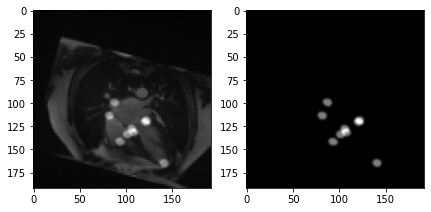

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.33203125 0.34765625
 0.4140625  0.546875   0.55078125 0.5546875  0.56640625 0.62890625
 0.6640625  0.6875     0.7421875  0.81640625 0.8203125  0.8359375
 0.84375    0.921875   0.9375     0.94140625 0.96484375 0.9765625
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.21484375
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.29296875
 0.296875   0.3125     0.33203125 0.41015625 0.4140625  0.48828125
 0.50390625 0.546875   0.55078125 0.56640625 0.5703125  0.6484375
 0.6640625  0.6875     0.72265625 0.7265625  0.7421875  0.81640625
 0.8203125  0.84375    0.859375   0.8984375  0.91796875 0.921875
 0.9375     0.94140625 0.9765625  0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 

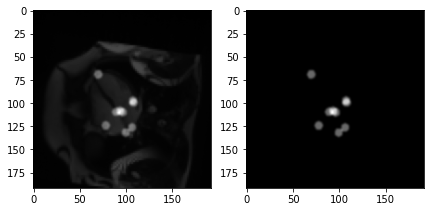

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.34765625 0.36328125
 0.4140625  0.546875   0.5546875  0.5703125  0.62890625 0.6328125
 0.6640625  0.6875     0.7421875  0.8359375  0.83984375 0.84375
 0.85546875 0.921875   0.9375     0.94140625 0.96484375 0.9765625
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.07421875 0.12109375 0.13671875 0.140625
 0.14453125 0.21875    0.23046875 0.234375   0.25390625 0.28125
 0.296875   0.3203125  0.33203125 0.34765625 0.4140625  0.4296875
 0.546875   0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.640625   0.6640625  0.6796875  0.7421875  0.765625   0.8203125
 0.82421875 0.8359375  0.83984375 0.84375    0.859375   0.90625
 0.921875   0.92578125 0.94140625 0.95703125 0.96484375 0.9765625
 0.98046875 0.9921875  0.99609375 1.        ]
[0.        

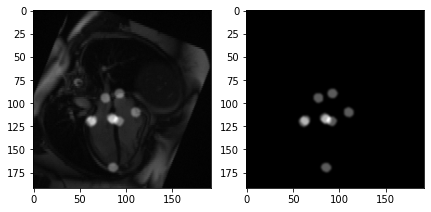

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.09765625 0.12109375 0.13671875
 0.14453125 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.28125    0.296875   0.3125     0.34765625 0.36328125 0.41015625
 0.4140625  0.50390625 0.546875   0.5546875  0.5703125  0.62890625
 0.6328125  0.640625   0.6640625  0.6875     0.7265625  0.7421875
 0.8359375  0.83984375 0.84375    0.85546875 0.859375   0.90625
 0.91796875 0.921875   0.9375     0.94140625 0.96484375 0.9765625
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.25390625 0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.41015625 0.4140625  0.50390625 0.55078125
 0.5546875  0.56640625 0.5703125  0.62890625 0.6328125  0.6640625
 0.6875     0.7265625  0.7421875  0.8203125  0.8359375  0.85546875
 0.859375   0.91796875

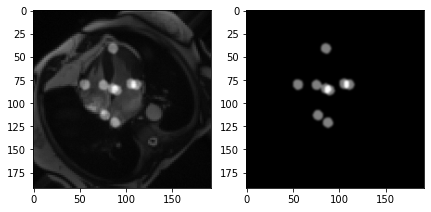

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.33203125 0.34765625
 0.4140625  0.546875   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.6640625  0.6875     0.7421875  0.8203125  0.8359375
 0.83984375 0.84375    0.921875   0.9375     0.94140625 0.96484375
 0.9765625  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.4140625
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.6640625
 0.6875     0.7421875  0.8203125  0.8359375  0.859375   0.921875
 0.9375     0.94140625 0.96484375 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125

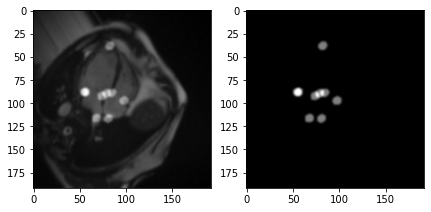

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.05859375 0.07421875 0.09765625 0.12109375
 0.125      0.13671875 0.140625   0.14453125 0.15625    0.21484375
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.296875
 0.31640625 0.34765625 0.390625   0.40625    0.41015625 0.4296875
 0.453125   0.48828125 0.50390625 0.546875   0.5546875  0.5703125
 0.62890625 0.6640625  0.72265625 0.7265625  0.75       0.765625
 0.78125    0.8359375  0.83984375 0.84375    0.859375   0.90234375
 0.91796875 0.921875   0.9375     0.953125   0.95703125 0.9609375
 0.96484375 0.9765625  0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.296875   0.3125     0.34765625 0.41015625
 0.50390625 0.5546875  0.5703125  0.62890625 0.6640625  0.6875
 0.7265625  0.8359375  0.859375   0.91796875 0.921875   0.9375
 0.96484375 0.980468

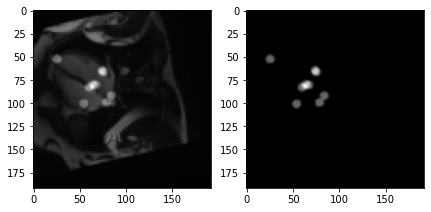

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.05859375
 0.12109375 0.13671875 0.21875    0.25390625 0.33203125 0.4140625
 0.546875   0.56640625 0.7421875  0.82421875 0.84375    0.94140625
 0.9765625  0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.0546875  0.05859375 0.0625     0.07421875 0.09765625
 0.12109375 0.125      0.13671875 0.14453125 0.15625    0.23046875
 0.234375   0.23828125 0.25390625 0.28125    0.296875   0.3125
 0.3203125  0.33203125 0.34765625 0.390625   0.40625    0.41015625
 0.4140625  0.453125   0.50390625 0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.640625   0.6640625  0.6796875  0.6875
 0.7265625  0.7421875  0.75       0.78125    0.81640625 0.8203125
 0.8359375  0.83984375 0.859375   0.90625    0.91796875 0.921875
 0.92578125 0.9375     0.94140625 0.953125   0.9609375  0.96484375
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04

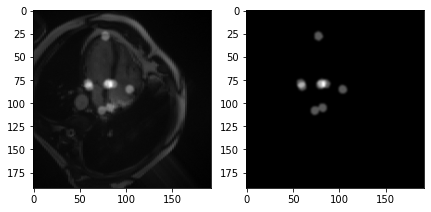

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.296875   0.3125     0.34765625 0.36328125
 0.41015625 0.50390625 0.5546875  0.5703125  0.62890625 0.6328125
 0.6640625  0.6875     0.7265625  0.8359375  0.85546875 0.859375
 0.91796875 0.921875   0.9375     0.96484375 0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.6328125  0.6640625  0.6875     0.7421875  0.8203125  0.8359375
 0.85546875 0.859375   0.921875   0.9375     0.94140625 0.96484375
 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.2539062

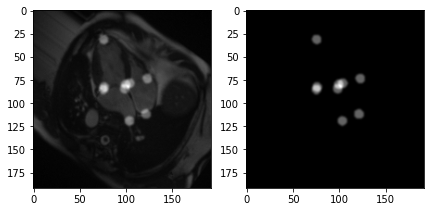

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.4140625  0.55078125 0.5546875  0.5703125  0.62890625 0.6328125
 0.6640625  0.6875     0.7421875  0.81640625 0.8359375  0.83984375
 0.85546875 0.859375   0.921875   0.9375     0.94140625 0.96484375
 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.14453125 0.23046875 0.296875   0.3125
 0.33203125 0.34765625 0.36328125 0.55078125 0.5546875  0.62890625
 0.6328125  0.6640625  0.6875     0.81640625 0.8359375  0.85546875
 0.921875   0.9375     0.96484375 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.14453125 0.23046875 0.296875   0.3125
 0.33203125 0.34765625 0.36328125 0.55078125 0.5546875  0.62890625
 0.6328125  0.6640625  0.6875     0.81640625 0.8

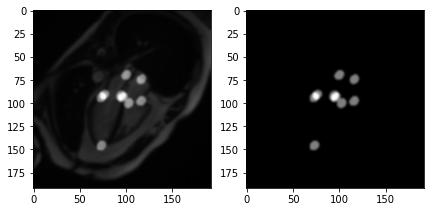

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6328125  0.640625   0.6640625  0.6875
 0.7421875  0.8203125  0.8359375  0.83984375 0.85546875 0.859375
 0.90625    0.921875   0.9375     0.94140625 0.96484375 0.98046875
 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.05859375 0.0625     0.07421875 0.09765625
 0.12109375 0.125      0.13671875 0.14453125 0.15625    0.21484375
 0.21875    0.23046875 0.23828125 0.25390625 0.296875   0.3125
 0.31640625 0.3203125  0.33203125 0.34765625 0.40625    0.41015625
 0.4140625  0.453125   0.48828125 0.546875   0.55078125 0.5546875
 0.5703125  0.62890625 0.6640625  0.6796875  0.6875     0.72265625
 0.7421875  0.75       0.78125    0.816

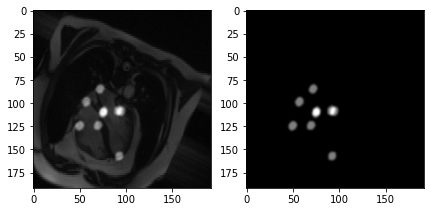

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.25390625 0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.41015625 0.4140625  0.50390625 0.55078125
 0.5546875  0.56640625 0.5703125  0.62890625 0.6328125  0.6640625
 0.6875     0.7265625  0.7421875  0.8203125  0.8359375  0.85546875
 0.859375   0.91796875 0.921875   0.9375     0.94140625 0.96484375
 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6328125  0.640625   0.6640625  0.6875
 0.7421875  0.8203125  0.8359375  0.83984375 0.85546875 0.859375
 0.90625    0.921875   0.9375     0.94140625 0.96484375 0.98046875
 0.9921875  0.99609375 1.        ]


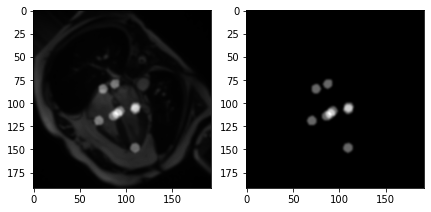

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.33203125 0.34765625
 0.4140625  0.546875   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.6640625  0.6875     0.7421875  0.81640625 0.8203125
 0.8359375  0.83984375 0.84375    0.921875   0.9375     0.94140625
 0.96484375 0.9765625  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.33203125 0.34765625
 0.4140625  0.546875   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.6640625  0.6875     0.7421875  0.81640625 0.8203125
 0.8359375  0.83984375 0.84375    0.921875   0.9375     0.94140625
 0.96484375 0.9765625  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.

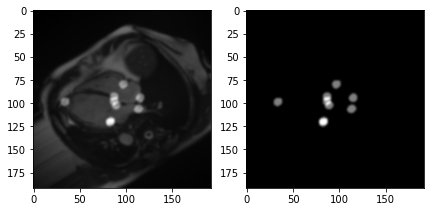

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21484375 0.23046875 0.234375   0.23828125 0.25390625 0.28125
 0.29296875 0.296875   0.3125     0.33203125 0.34765625 0.41015625
 0.4140625  0.48828125 0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.640625   0.6484375  0.6640625  0.6875     0.72265625
 0.7421875  0.8203125  0.82421875 0.8359375  0.859375   0.8984375
 0.90625    0.921875   0.9375     0.94140625 0.96484375 0.98046875
 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.07421875 0.09765625 0.12109375 0.13671875
 0.140625   0.14453125 0.21875    0.23046875 0.234375   0.23828125
 0.25390625 0.28125    0.296875   0.3203125  0.34765625 0.36328125
 0.41015625 0.4140625  0.4296875  0.50390625 0.546875   0.5546875
 0.5703125  0.62890625 0.6328125  0.640625   0.6640625  0.6796875
 0.7265625  0.7421875  0.765625   0

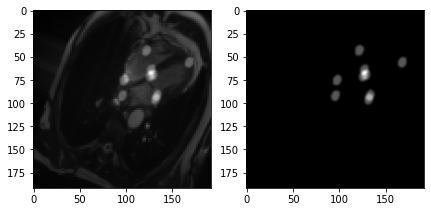

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.0546875  0.05859375 0.0625     0.07421875
 0.09765625 0.12109375 0.125      0.13671875 0.14453125 0.15625
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.2578125
 0.28125    0.296875   0.3125     0.3203125  0.33203125 0.34765625
 0.390625   0.40625    0.41015625 0.4140625  0.453125   0.50390625
 0.546875   0.55078125 0.5546875  0.56640625 0.5703125  0.5859375
 0.62890625 0.640625   0.6640625  0.6796875  0.6875     0.7265625
 0.7421875  0.75       0.78125    0.8203125  0.8359375  0.83984375
 0.84375    0.859375   0.86328125 0.90625    0.91796875 0.921875
 0.92578125 0.9375     0.94140625 0.953125   0.9609375  0.96484375
 0.9765625  0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.2578125
 0.296875   0.

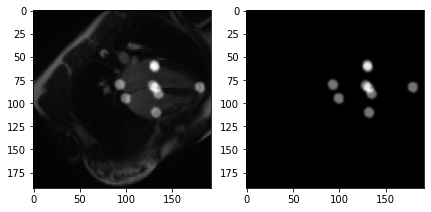

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.07421875 0.12109375 0.125
 0.13671875 0.14453125 0.15625    0.23046875 0.234375   0.25390625
 0.296875   0.3125     0.3203125  0.33203125 0.34765625 0.36328125
 0.390625   0.40625    0.4140625  0.453125   0.55078125 0.5546875
 0.56640625 0.5703125  0.62890625 0.6328125  0.6640625  0.6796875
 0.6875     0.7265625  0.7421875  0.75       0.78125    0.8203125
 0.8359375  0.83984375 0.85546875 0.859375   0.921875   0.92578125
 0.9375     0.94140625 0.953125   0.9609375  0.96484375 0.98046875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.36328125 0.41015625 0.4140625
 0.50390625 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.6328125  0.640625   0.6640625  0.6875     0.726

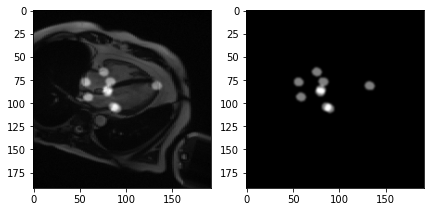

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.5546875  0.56640625 0.5703125  0.62890625 0.640625   0.6640625
 0.6875     0.7265625  0.7421875  0.82421875 0.8359375  0.83984375
 0.859375   0.90625    0.91796875 0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.5546875  0.56640625 0.5703125
 0.62890625 0.6328125  0.640625   0.6640625  0.6875     0.7421875
 0.82421875 0.8359375  0.83984375 0.85546875 0.859375   0.90625
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.9921875
 0.99609375 1.  

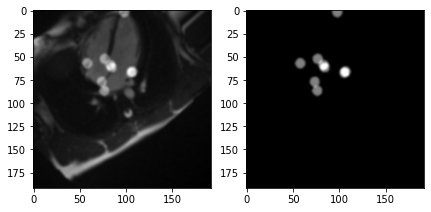

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.0546875  0.05859375 0.0625     0.07421875
 0.12109375 0.125      0.13671875 0.14453125 0.15625    0.21875
 0.23046875 0.234375   0.25390625 0.28125    0.296875   0.3125
 0.3203125  0.33203125 0.34765625 0.390625   0.40625    0.4140625
 0.453125   0.546875   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.640625   0.6640625  0.6796875  0.6875     0.7265625
 0.7421875  0.75       0.78125    0.8203125  0.8359375  0.83984375
 0.84375    0.859375   0.90625    0.921875   0.92578125 0.9375
 0.94140625 0.953125   0.9609375  0.96484375 0.9765625  0.98046875
 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.55078125 0.5546875  0.56640625 0.5703125 

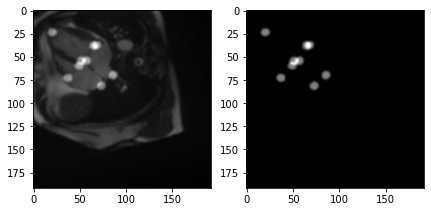

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.05859375 0.0625     0.07421875 0.12109375
 0.125      0.13671875 0.140625   0.14453125 0.15625    0.21875
 0.23046875 0.234375   0.25390625 0.296875   0.3125     0.3203125
 0.33203125 0.34765625 0.36328125 0.390625   0.40625    0.4140625
 0.4296875  0.453125   0.546875   0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6328125  0.6640625  0.6796875  0.6875
 0.7265625  0.7421875  0.75       0.765625   0.78125    0.8203125
 0.8359375  0.83984375 0.84375    0.85546875 0.859375   0.921875
 0.92578125 0.9375     0.94140625 0.953125   0.95703125 0.9609375
 0.96484375 0.9765625  0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.07421875 0.09765625 0.12109375 0.13671875
 0.140625   0.21484375 0.21875    0.234375   0.23828125 0.25390625
 0.2578125  0.28125    0.296875   0.31640625 0.33203125 0.41015625
 0.4140625  0.4296

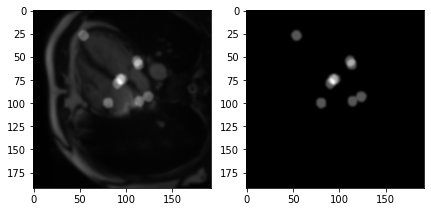

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.07421875 0.09765625 0.12109375 0.13671875 0.140625
 0.14453125 0.23046875 0.234375   0.23828125 0.25390625 0.2578125
 0.28125    0.3203125  0.33203125 0.34765625 0.41015625 0.4140625
 0.4296875  0.50390625 0.55078125 0.5546875  0.56640625 0.5703125
 0.5859375  0.62890625 0.640625   0.6796875  0.7265625  0.7421875
 0.765625   0.8203125  0.8359375  0.83984375 0.859375   0.86328125
 0.90625    0.91796875 0.92578125 0.94140625 0.95703125 0.96484375
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.21875
 0.23046875 0.234375   0.23828125 0.25390625 0.296875   0.3125
 0.33203125 0.41015625 0.4140625  0.50390625 0.546875   0.55078125
 0.56640625 0.5703125  0.6640625  0.6875     0.7265625  0.7421875
 0.8203125  0.82421875 0.84375    0.859375   0.91796875 0.921875
 0.9375     0.94140625 0.9765625 

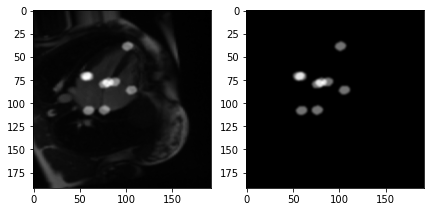

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.07421875 0.12109375 0.13671875 0.140625   0.14453125
 0.23046875 0.234375   0.25390625 0.28125    0.296875   0.3203125
 0.33203125 0.34765625 0.36328125 0.4140625  0.4296875  0.55078125
 0.5546875  0.56640625 0.5703125  0.6328125  0.640625   0.6640625
 0.6796875  0.7421875  0.765625   0.8203125  0.8359375  0.83984375
 0.85546875 0.859375   0.90625    0.921875   0.92578125 0.94140625
 0.95703125 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.4140625  0.55078125 0.5546875  0.5703125  0.62890625 0.6328125
 0.6640625  0.6875     0.7421875  0.81640625 0.8359375  0.83984375
 0.85546875 0.859375   0.921875   0.9375     0.94140625 0.96484375
 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.015625 

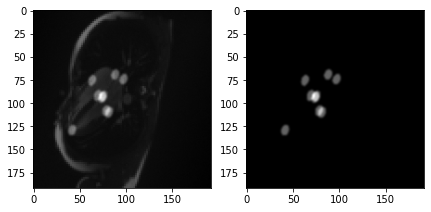

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.55078125 0.5546875  0.5703125  0.62890625 0.640625   0.6640625
 0.6875     0.7265625  0.7421875  0.81640625 0.8359375  0.83984375
 0.859375   0.90625    0.91796875 0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21484375 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.29296875 0.296875   0.3125     0.34765625 0.36328125 0.41015625
 0.4140625  0.48828125 0.50390625 0.53125    0.546875   0.5546875
 0.5703125  0.62890625 0.6328125  0.6484375  0.6640625  0.6875
 0.72265625 0.7265625  0.7421875  0.8203125  0.8359375  0.83984375
 0.84375    0.

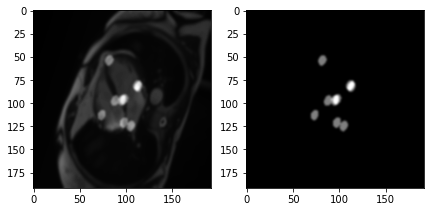

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.07421875 0.12109375 0.125
 0.13671875 0.14453125 0.15625    0.23046875 0.234375   0.25390625
 0.296875   0.3125     0.3203125  0.33203125 0.34765625 0.40625
 0.4140625  0.453125   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.6640625  0.6796875  0.6875     0.7421875  0.75
 0.78125    0.8203125  0.8359375  0.859375   0.921875   0.92578125
 0.9375     0.94140625 0.953125   0.9609375  0.96484375 0.98046875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.34765625 0.4140625
 0.546875   0.5546875  0.5703125  0.62890625 0.6640625  0.6875
 0.7421875  0.8359375  0.83984375 0.84375    0.921875   0.9375
 0.94140625 0.96484375 0.9765625  0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296

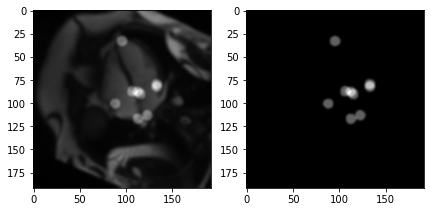

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.09765625 0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.28125
 0.296875   0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.546875   0.5546875  0.56640625 0.5703125  0.62890625 0.640625
 0.6640625  0.7265625  0.7421875  0.82421875 0.8359375  0.83984375
 0.84375    0.859375   0.90625    0.91796875 0.921875   0.94140625
 0.96484375 0.9765625  0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.640625   0.6640625  0.6875     0.7421875  0.8203125
 0.8359375  0.859375   0.90625    0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         

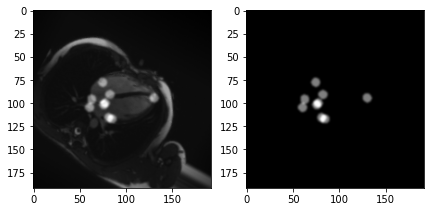

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.07421875 0.12109375 0.13671875
 0.140625   0.14453125 0.21875    0.23046875 0.234375   0.25390625
 0.28125    0.296875   0.3125     0.3203125  0.33203125 0.34765625
 0.36328125 0.4140625  0.4296875  0.546875   0.55078125 0.5546875
 0.56640625 0.5703125  0.62890625 0.6328125  0.640625   0.6640625
 0.6796875  0.6875     0.7421875  0.765625   0.81640625 0.8203125
 0.8359375  0.83984375 0.84375    0.85546875 0.859375   0.90625
 0.921875   0.92578125 0.9375     0.94140625 0.95703125 0.96484375
 0.9765625  0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.0546875  0.05859375 0.0625     0.07421875 0.09765625
 0.12109375 0.125      0.13671875 0.14453125 0.15625    0.21484375
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.31640625 0.34765625 0.390625   0.40625    0.41015625
 0.4140625  0

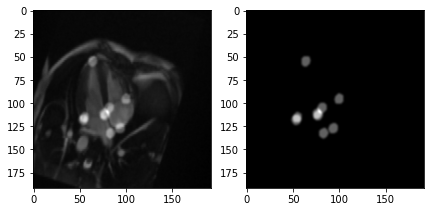

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.640625   0.6640625  0.6875     0.7421875  0.8203125
 0.8359375  0.83984375 0.859375   0.90625    0.921875   0.9375
 0.94140625 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.0546875  0.05859375 0.0625     0.10546875 0.12109375
 0.13671875 0.14453125 0.15234375 0.23046875 0.234375   0.25390625
 0.28125    0.296875   0.3125     0.32421875 0.34765625 0.36328125
 0.390625   0.4140625  0.4375     0.5546875  0.5703125  0.6171875
 0.62890625 0.6328125  0.640625   0.6640625  0.6875     0.7265625
 0.7421875  0.7578125  0.8359375  0.83984375 0.8515625  0.859375
 0.90625    0.921875   0.9375     0.94140625 0.9453125  0.96484375
 0.98

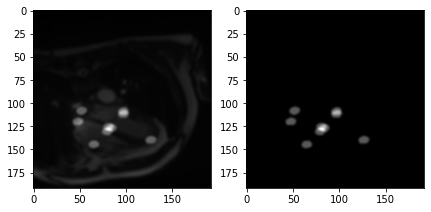

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.36328125 0.4140625  0.546875
 0.5546875  0.56640625 0.5703125  0.62890625 0.6328125  0.640625
 0.6640625  0.6875     0.7421875  0.82421875 0.8359375  0.83984375
 0.84375    0.85546875 0.859375   0.90625    0.921875   0.9375
 0.94140625 0.96484375 0.9765625  0.98046875 0.9921875  0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.09765625 0.12109375 0.13671875 0.14453125 0.234375
 0.23828125 0.25390625 0.28125    0.296875   0.33203125 0.34765625
 0.41015625 0.4140625  0.50390625 0.56640625 0.5703125  0.62890625
 0.640625   0.6640625  0.7265625  0.7421875  0.82421875 0.83984375
 0.859375   0.90625    0.91796875 0.921875   0.94140625 0.96484375
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00

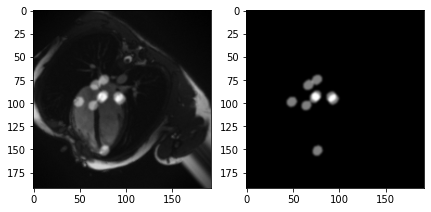

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.4140625  0.5546875  0.56640625 0.5703125  0.62890625 0.6328125
 0.6640625  0.6875     0.7421875  0.82421875 0.8359375  0.85546875
 0.859375   0.921875   0.9375     0.94140625 0.96484375 0.98046875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.2578125  0.28125
 0.296875   0.3125     0.33203125 0.34765625 0.41015625 0.4140625
 0.50390625 0.55078125 0.5546875  0.56640625 0.5703125  0.5859375
 0.62890625 0.640625   0.6640625  0.6875     0.7265625  0.7421875
 0.8203125  0.8359375  0.859375   0.86328125 0.90625    0.91796875
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0.00390625 0.

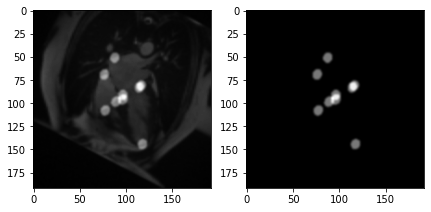

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.5546875  0.56640625 0.5703125  0.62890625
 0.640625   0.6640625  0.6875     0.7421875  0.82421875 0.8359375
 0.859375   0.90625    0.921875   0.9375     0.94140625 0.96484375
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.21484375
 0.23046875 0.234375   0.23828125 0.2578125  0.28125    0.29296875
 0.296875   0.3125     0.33203125 0.41015625 0.4140625  0.48828125
 0.50390625 0.55078125 0.5703125  0.5859375  0.640625   0.6484375
 0.6640625  0.6875     0.72265625 0.7265625  0.7421875  0.81640625
 0.859375   0.86328125 0.8984375  0.90625    0.91796875 0.921875
 0.9375     0.94140625 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.0039062

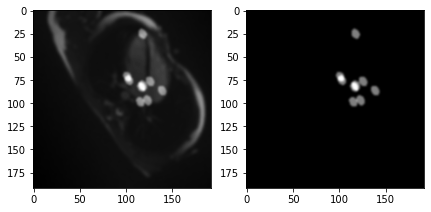

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.34765625 0.41015625 0.4140625  0.50390625 0.5546875
 0.5703125  0.62890625 0.640625   0.6640625  0.6875     0.7265625
 0.7421875  0.8359375  0.83984375 0.859375   0.90625    0.91796875
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.05859375 0.0625     0.07421875 0.12109375
 0.125      0.13671875 0.14453125 0.15625    0.21484375 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.3203125  0.33203125
 0.34765625 0.36328125 0.40625    0.4140625  0.453125   0.53125
 0.546875   0.55078125 0.5546875  0.56640625 0.62890625 0.6328125
 0.6640625  0.6796875  0.6875     0.7421875  0.75       0.78125
 0.8203125  0.8359375  0.84375    0.85546875 0.921875 

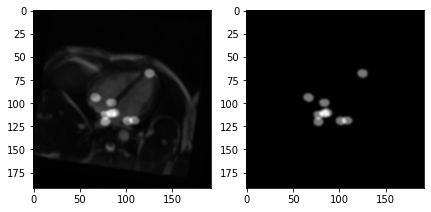

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.296875
 0.3125     0.34765625 0.41015625 0.4140625  0.50390625 0.546875
 0.5546875  0.5703125  0.62890625 0.6640625  0.6875     0.7265625
 0.7421875  0.8359375  0.83984375 0.84375    0.859375   0.91796875
 0.921875   0.9375     0.94140625 0.96484375 0.9765625  0.98046875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.4140625  0.546875   0.5546875
 0.56640625 0.5703125  0.62890625 0.640625   0.6640625  0.6875
 0.7421875  0.82421875 0.8359375  0.83984375 0.84375    0.859375
 0.90625    0.921875   0.9375     0.94140625 0.96484375 0.9765625
 0.98046875 0.9921875  0.99609375 1.        ]
[0.    

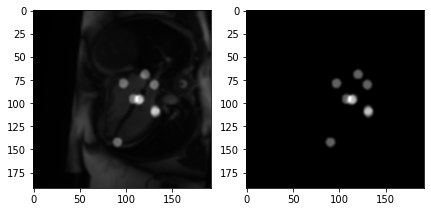

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.07421875 0.12109375 0.140625   0.14453125
 0.21875    0.23046875 0.296875   0.3125     0.3203125  0.33203125
 0.34765625 0.4296875  0.546875   0.55078125 0.5546875  0.62890625
 0.6640625  0.6796875  0.6875     0.765625   0.81640625 0.8359375
 0.84375    0.921875   0.92578125 0.9375     0.95703125 0.96484375
 0.9765625  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.07421875 0.12109375 0.13671875 0.140625
 0.14453125 0.23046875 0.234375   0.25390625 0.28125    0.296875
 0.3125     0.3203125  0.33203125 0.34765625 0.4140625  0.4296875
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.640625
 0.6640625  0.6796875  0.6875     0.7421875  0.765625   0.81640625
 0.8203125  0.8359375  0.859375   0.90625    0.921875   0.92578125
 0.9375     0.94140625 0.95703125 0.96484375 0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0

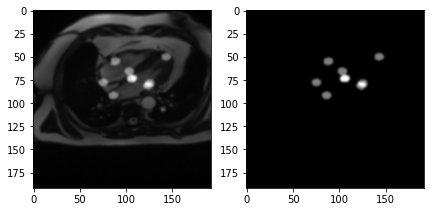

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.0546875  0.05859375 0.0625     0.07421875 0.12109375
 0.125      0.13671875 0.14453125 0.15625    0.23046875 0.234375
 0.25390625 0.28125    0.296875   0.3125     0.3203125  0.33203125
 0.34765625 0.36328125 0.390625   0.40625    0.4140625  0.453125
 0.5546875  0.56640625 0.5703125  0.62890625 0.6328125  0.640625
 0.6640625  0.6796875  0.6875     0.7265625  0.7421875  0.75
 0.78125    0.82421875 0.8359375  0.83984375 0.85546875 0.859375
 0.90625    0.921875   0.92578125 0.9375     0.94140625 0.953125
 0.9609375  0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.640625   0.6640625  0.6875     0.7421875  0.8203125
 0.82421875 0

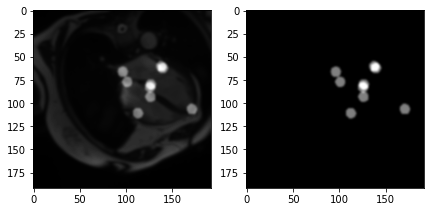

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.09765625 0.12109375 0.13671875
 0.14453125 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.28125    0.296875   0.3125     0.33203125 0.34765625 0.41015625
 0.4140625  0.50390625 0.546875   0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.640625   0.6640625  0.6875     0.7265625
 0.7421875  0.8203125  0.8359375  0.83984375 0.84375    0.859375
 0.90625    0.91796875 0.921875   0.9375     0.94140625 0.96484375
 0.9765625  0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.28125    0.296875   0.34765625 0.41015625
 0.50390625 0.5546875  0.5703125  0.62890625 0.640625   0.6640625
 0.7265625  0.8359375  0.859375   0.90625    0.91796875 0.921875
 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625

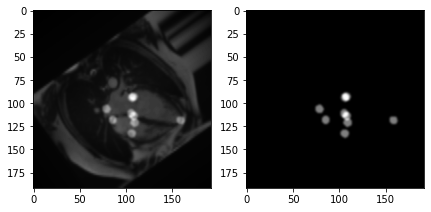

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21484375
 0.21875    0.23046875 0.25390625 0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.53125    0.546875   0.55078125
 0.5546875  0.56640625 0.5703125  0.62890625 0.6328125  0.63671875
 0.6640625  0.6875     0.7421875  0.8203125  0.8359375  0.83984375
 0.84375    0.85546875 0.921875   0.9375     0.94140625 0.9609375
 0.96484375 0.9765625  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.09765625 0.12109375 0.13671875
 0.14453125 0.16015625 0.21484375 0.21875    0.23046875 0.234375
 0.23828125 0.25390625 0.28125    0.29296875 0.296875   0.3125
 0.34765625 0.3515625  0.36328125 0.41015625 0.4140625  0.42578125
 0.48828125 0.50390625 0.546875   0.5546875  0.5703125  0.6328125
 0.640625   0.6484375  0.6640625  0.6875     0.72265625 0.7265625
 0.73046875 0.7421875  0.

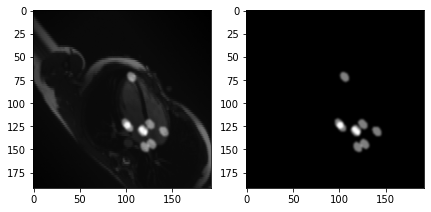

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6328125  0.640625   0.6640625  0.6875
 0.7421875  0.8203125  0.8359375  0.85546875 0.859375   0.90625
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.12109375 0.14453125 0.15625
 0.23046875 0.25390625 0.296875   0.3125     0.34765625 0.390625
 0.453125   0.5546875  0.5703125  0.62890625 0.6640625  0.6875
 0.7265625  0.78125    0.8359375  0.83984375 0.921875   0.9375
 0.9609375  0.96484375 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.05859375 0.0625     0.07421875 0.09765625
 0.12109375 0.

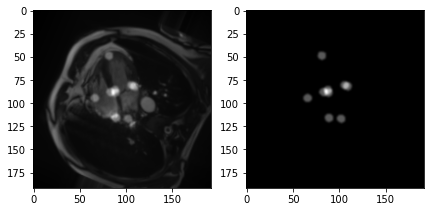

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21484375 0.23046875 0.234375   0.23828125 0.28125    0.29296875
 0.296875   0.3125     0.34765625 0.36328125 0.41015625 0.48828125
 0.50390625 0.5546875  0.5703125  0.62890625 0.6328125  0.640625
 0.6484375  0.6640625  0.6875     0.72265625 0.7265625  0.8359375
 0.85546875 0.859375   0.8984375  0.90625    0.91796875 0.921875
 0.9375     0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.09765625 0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.234375   0.23828125 0.25390625 0.296875   0.33203125
 0.34765625 0.41015625 0.4140625  0.50390625 0.546875   0.55078125
 0.5546875  0.56640625 0.5703125  0.62890625 0.6640625  0.7265625
 0.7421875  0.8203125  0.82421875 0.8359375  0.83984375 0.84375
 0.859375   0.91796875 0.921875   0.94140625 0.96484375 0.9765625
 0.98046

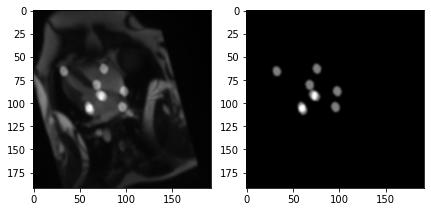

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.07421875 0.12109375 0.13671875
 0.140625   0.14453125 0.21484375 0.21875    0.23046875 0.234375
 0.25390625 0.28125    0.296875   0.3125     0.3203125  0.33203125
 0.34765625 0.36328125 0.4140625  0.4296875  0.53125    0.546875
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.6328125
 0.640625   0.6640625  0.6796875  0.6875     0.7421875  0.765625
 0.8203125  0.8359375  0.83984375 0.84375    0.85546875 0.859375
 0.90625    0.921875   0.92578125 0.9375     0.94140625 0.95703125
 0.9609375  0.96484375 0.9765625  0.98046875 0.9921875  0.99609375
 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.12109375 0.13671875 0.14453125
 0.15625    0.23046875 0.234375   0.25390625 0.296875   0.3125
 0.33203125 0.34765625 0.390625   0.4140625  0.453125   0.55078125
 0.5546875  0.56640625 0.5703125  0.62890625 0.6640625  0.6875

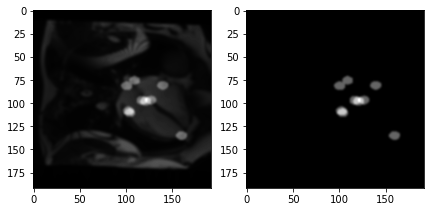

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.640625   0.6640625  0.6875     0.7421875  0.8203125
 0.8359375  0.83984375 0.859375   0.90625    0.921875   0.9375
 0.94140625 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.2578125
 0.296875   0.3125     0.33203125 0.34765625 0.41015625 0.4140625
 0.50390625 0.546875   0.55078125 0.5546875  0.56640625 0.5703125
 0.5859375  0.62890625 0.6640625  0.6875     0.7265625  0.7421875
 0.8203125  0.8359375  0.83984375 0.84375    0.859375   0.86328125
 0.91796875 0.921875   0.9375     0.94140625 0.96484375 0.9765625
 0.980

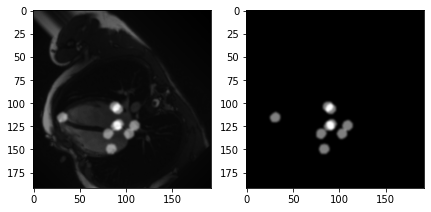

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.12109375 0.14453125 0.15625
 0.23046875 0.25390625 0.296875   0.3125     0.33203125 0.34765625
 0.390625   0.453125   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.6640625  0.6875     0.7265625  0.78125    0.81640625
 0.8203125  0.8359375  0.83984375 0.921875   0.9375     0.9609375
 0.96484375 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.09765625 0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.28125
 0.296875   0.33203125 0.34765625 0.36328125 0.41015625 0.4140625
 0.50390625 0.546875   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.6328125  0.640625   0.6640625  0.7265625  0.7421875
 0.8203125  0.8359375  0.83984375 0.84375    0.85546875 0.859375
 0.90625    0.91796875 0.921875   0.94140625 0.96484375 0.9765625
 0.98046875 0.9921875  0.99609375 1.     

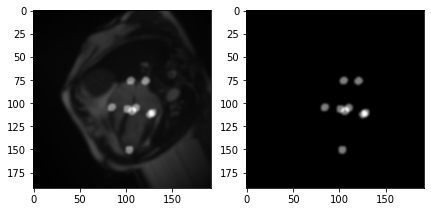

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.296875   0.3125     0.34765625 0.36328125
 0.41015625 0.50390625 0.5546875  0.5703125  0.62890625 0.6328125
 0.6640625  0.6875     0.7265625  0.8359375  0.85546875 0.859375
 0.91796875 0.921875   0.9375     0.96484375 0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.4140625  0.546875   0.55078125
 0.5546875  0.56640625 0.5703125  0.62890625 0.640625   0.6640625
 0.6875     0.7421875  0.8203125  0.82421875 0.8359375  0.83984375
 0.84375    0.859375   0.90625    0.921875   0.9375     0.94140625
 0.96484375 0.9765625  0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625

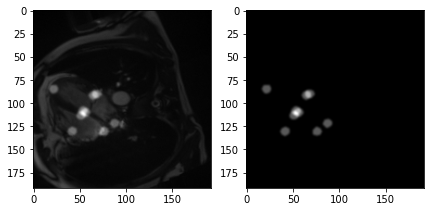

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.33203125 0.34765625
 0.4140625  0.546875   0.55078125 0.5546875  0.56640625 0.62890625
 0.6640625  0.6875     0.7421875  0.81640625 0.8203125  0.8359375
 0.84375    0.921875   0.9375     0.94140625 0.96484375 0.9765625
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.14453125 0.23046875 0.296875   0.3125
 0.33203125 0.34765625 0.55078125 0.5546875  0.62890625 0.6640625
 0.6875     0.81640625 0.8359375  0.921875   0.9375     0.96484375
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.28125    0.296875   0.3125
 0.33203125 0.34765625 0.41015625 0.50390625 0.55078125 0.5546875
 0.5703125  0.62890625 0.64062

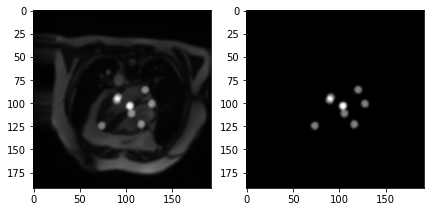

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.05859375 0.0625     0.09765625 0.12109375
 0.13671875 0.14453125 0.15625    0.21875    0.23046875 0.234375
 0.23828125 0.25390625 0.296875   0.3125     0.33203125 0.34765625
 0.390625   0.41015625 0.4140625  0.453125   0.50390625 0.546875
 0.55078125 0.56640625 0.5703125  0.62890625 0.6640625  0.6875
 0.7265625  0.7421875  0.78125    0.8203125  0.83984375 0.84375
 0.859375   0.91796875 0.921875   0.9375     0.94140625 0.9609375
 0.96484375 0.9765625  0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.14453125 0.23046875 0.296875   0.3125
 0.33203125 0.34765625 0.55078125 0.5546875  0.62890625 0.6640625
 0.6875     0.81640625 0.8359375  0.921875   0.9375     0.96484375
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.1445312

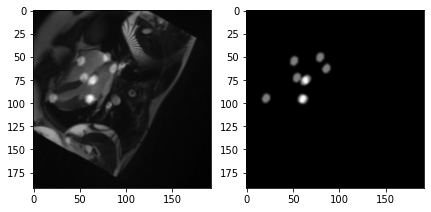

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.0546875  0.05859375 0.0625     0.12109375 0.13671875
 0.14453125 0.15625    0.23046875 0.234375   0.25390625 0.28125
 0.296875   0.3125     0.33203125 0.34765625 0.36328125 0.390625
 0.4140625  0.453125   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.6328125  0.640625   0.6640625  0.6875     0.7265625
 0.7421875  0.78125    0.8203125  0.8359375  0.83984375 0.85546875
 0.859375   0.90625    0.921875   0.9375     0.94140625 0.9609375
 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21484375 0.23046875 0.234375   0.23828125 0.28125    0.29296875
 0.296875   0.3125     0.34765625 0.41015625 0.48828125 0.50390625
 0.5546875  0.5703125  0.62890625 0.640625   0.6484375  0.6640625
 0.6875     0.72265625 0.7265625  0.8359375  0.859375   0.8984375
 0.90625    0.91

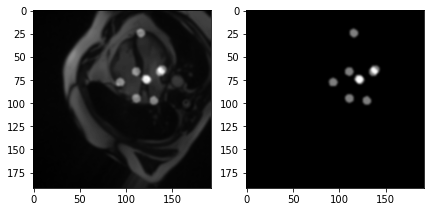

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.07421875 0.12109375 0.125
 0.13671875 0.14453125 0.15625    0.23046875 0.234375   0.25390625
 0.296875   0.3125     0.3203125  0.33203125 0.34765625 0.390625
 0.40625    0.4140625  0.453125   0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6640625  0.6796875  0.6875     0.7265625
 0.7421875  0.75       0.78125    0.8203125  0.8359375  0.83984375
 0.859375   0.921875   0.92578125 0.9375     0.94140625 0.953125
 0.9609375  0.96484375 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.5546875  0.56640625 0.5703125
 0.62890625 0.6328125  0.640625   0.6640625  0.6875     0.7421875
 0.82421875 0.8359375  0.83984375 0.85546875 0.859375   0.90625
 0.921875   0.9375   

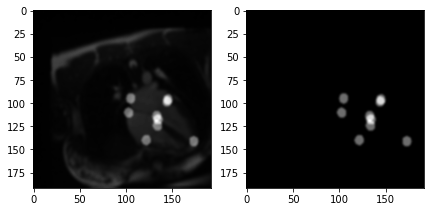

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.09765625 0.12109375 0.13671875
 0.14453125 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.28125    0.296875   0.3125     0.33203125 0.34765625 0.41015625
 0.4140625  0.50390625 0.546875   0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.640625   0.6640625  0.6875     0.7265625
 0.7421875  0.81640625 0.8203125  0.8359375  0.83984375 0.84375
 0.859375   0.90625    0.91796875 0.921875   0.9375     0.94140625
 0.96484375 0.9765625  0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.28125    0.296875   0.3125
 0.33203125 0.34765625 0.41015625 0.50390625 0.55078125 0.5546875
 0.5703125  0.62890625 0.640625   0.6640625  0.6875     0.7265625
 0.81640625 0.8359375  0.859375   0.90625    0.91796875 0.921875
 0.9375

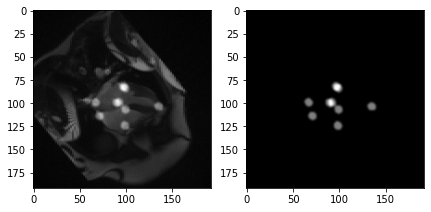

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.07421875 0.09765625 0.12109375
 0.13671875 0.140625   0.14453125 0.21875    0.23046875 0.234375
 0.23828125 0.25390625 0.28125    0.296875   0.3125     0.3203125
 0.33203125 0.34765625 0.36328125 0.41015625 0.4140625  0.4296875
 0.50390625 0.546875   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.6328125  0.640625   0.6640625  0.6796875  0.6875
 0.7265625  0.7421875  0.765625   0.8203125  0.8359375  0.83984375
 0.84375    0.85546875 0.859375   0.90625    0.91796875 0.921875
 0.92578125 0.9375     0.94140625 0.95703125 0.96484375 0.9765625
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.05859375 0.0625     0.07421875 0.12109375
 0.125      0.13671875 0.14453125 0.15625    0.21484375 0.21875
 0.23046875 0.234375   0.25390625 0.296875   0.3125     0.3203125
 0.33203125 0.34765625 0.3632812

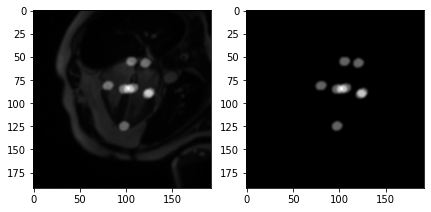

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.09765625 0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.234375   0.23828125 0.25390625 0.2578125  0.296875
 0.34765625 0.36328125 0.41015625 0.4140625  0.50390625 0.546875
 0.5546875  0.5703125  0.5859375  0.62890625 0.6328125  0.6640625
 0.7265625  0.7421875  0.8359375  0.83984375 0.84375    0.85546875
 0.859375   0.86328125 0.91796875 0.921875   0.94140625 0.96484375
 0.9765625  0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.234375   0.25390625 0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.546875   0.5546875  0.56640625
 0.5703125  0.62890625 0.6328125  0.6640625  0.6875     0.7421875
 0.82421875 0.8359375  0.83984375 0.84375    0.85546875 0.859375
 0.921875   0.9375     0.94140625 0.96484375 0.9765625  0.98046875
 0.99609375 1.        ]
[0.   

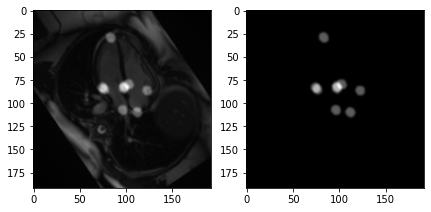

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.28125    0.296875   0.3125
 0.34765625 0.41015625 0.50390625 0.5546875  0.5703125  0.62890625
 0.640625   0.6640625  0.6875     0.7265625  0.8359375  0.859375
 0.90625    0.91796875 0.921875   0.9375     0.96484375 0.98046875
 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.12109375 0.13671875 0.14453125
 0.15625    0.23046875 0.234375   0.25390625 0.296875   0.3125
 0.33203125 0.34765625 0.390625   0.4140625  0.453125   0.55078125
 0.5546875  0.56640625 0.5703125  0.62890625 0.6640625  0.6875
 0.7265625  0.7421875  0.78125    0.8203125  0.8359375  0.83984375
 0.859375   0.921875   0.9375     0.94140625 0.9609375  0.96484375
 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0429

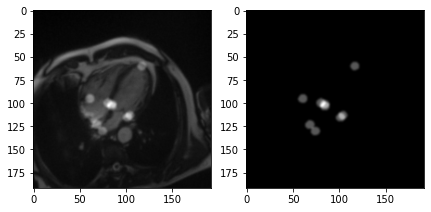

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.296875   0.3125     0.34765625 0.36328125
 0.41015625 0.50390625 0.5546875  0.5703125  0.62890625 0.6328125
 0.6640625  0.6875     0.7265625  0.8359375  0.85546875 0.859375
 0.91796875 0.921875   0.9375     0.96484375 0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.234375   0.25390625 0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.546875   0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6640625  0.6875     0.7421875  0.8203125
 0.82421875 0.8359375  0.84375    0.859375   0.921875   0.9375
 0.94140625 0.96484375 0.9765625  0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.1

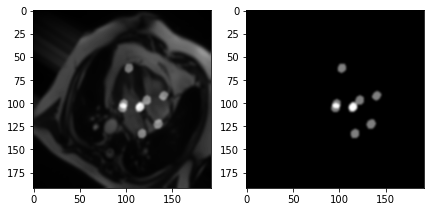

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.0546875  0.05859375 0.0625     0.09765625
 0.12109375 0.13671875 0.15625    0.21875    0.23046875 0.234375
 0.23828125 0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.390625   0.41015625 0.4140625  0.453125   0.50390625 0.546875
 0.55078125 0.56640625 0.5703125  0.640625   0.6640625  0.6875
 0.7265625  0.7421875  0.78125    0.8203125  0.82421875 0.84375
 0.859375   0.90625    0.91796875 0.921875   0.9375     0.94140625
 0.9609375  0.9765625  0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.4140625
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.6640625
 0.6875     0.7421875  0.81640625 0.8203125  0.8359375  0.859375
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.99609375
 1.        

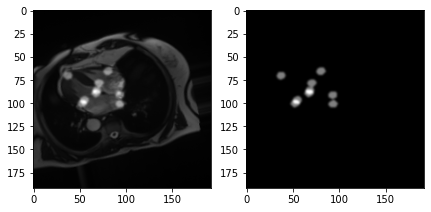

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21484375
 0.21875    0.23046875 0.234375   0.25390625 0.296875   0.3125
 0.33203125 0.34765625 0.36328125 0.4140625  0.53125    0.546875
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.6328125
 0.6640625  0.6875     0.7421875  0.8203125  0.82421875 0.8359375
 0.83984375 0.84375    0.85546875 0.859375   0.921875   0.9375
 0.94140625 0.9609375  0.96484375 0.9765625  0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.07421875 0.12109375 0.13671875 0.140625
 0.14453125 0.21875    0.23046875 0.25390625 0.296875   0.3125
 0.3203125  0.33203125 0.34765625 0.4140625  0.4296875  0.546875
 0.55078125 0.5546875  0.56640625 0.62890625 0.6640625  0.6796875
 0.6875     0.7421875  0.765625   0.8203125  0.8359375  0.84375
 0.921875   0.92578125 0.9375     0.94140625 0.95703125 0.96484375
 0.976

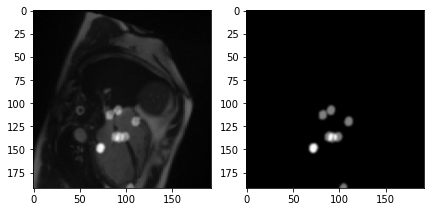

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.09765625 0.12109375 0.13671875
 0.14453125 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.2578125  0.28125    0.296875   0.3125     0.33203125 0.34765625
 0.41015625 0.4140625  0.50390625 0.546875   0.5546875  0.56640625
 0.5703125  0.5859375  0.62890625 0.640625   0.6640625  0.6875
 0.7265625  0.7421875  0.82421875 0.8359375  0.84375    0.859375
 0.86328125 0.90625    0.91796875 0.921875   0.9375     0.94140625
 0.96484375 0.9765625  0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.07421875 0.09765625 0.12109375
 0.125      0.13671875 0.14453125 0.15625    0.21484375 0.23046875
 0.234375   0.23828125 0.29296875 0.296875   0.3125     0.3203125
 0.33203125 0.34765625 0.36328125 0.40625    0.41015625 0.453125
 0.48828125 0.55078125 0.5546875  0.5703125  0.62890625 0.6328125
 0.6

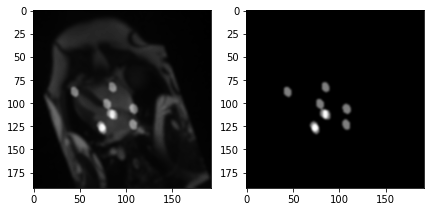

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.5546875  0.56640625 0.5703125  0.62890625
 0.640625   0.6640625  0.6875     0.7421875  0.82421875 0.8359375
 0.83984375 0.859375   0.90625    0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.4140625  0.5546875  0.56640625 0.5703125  0.62890625 0.6328125
 0.6640625  0.6875     0.7421875  0.82421875 0.8359375  0.85546875
 0.859375   0.921875   0.9375     0.94140625 0.96484375 0.98046875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.1445312

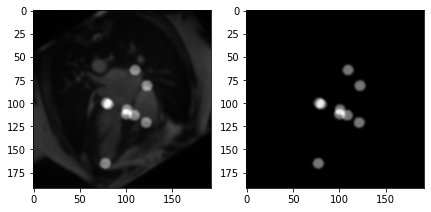

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.5703125
 0.62890625 0.6328125  0.640625   0.6640625  0.6875     0.7421875
 0.81640625 0.8359375  0.83984375 0.85546875 0.859375   0.90625
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.5703125
 0.62890625 0.6328125  0.640625   0.6640625  0.6875     0.7421875
 0.81640625 0.8359375  0.83984375 0.85546875 0.859375   0.90625
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0.00390625 0.015

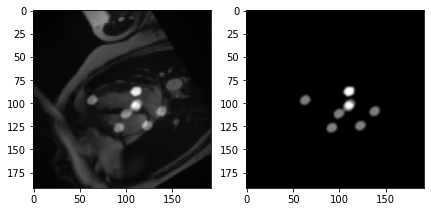

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.09765625 0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.28125
 0.296875   0.34765625 0.41015625 0.4140625  0.50390625 0.546875
 0.5546875  0.5703125  0.62890625 0.640625   0.6640625  0.7265625
 0.7421875  0.8359375  0.83984375 0.84375    0.859375   0.90625
 0.91796875 0.921875   0.94140625 0.96484375 0.9765625  0.98046875
 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.640625
 0.6640625  0.6875     0.7265625  0.7421875  0.8203125  0.8359375
 0.859375   0.90625    0.91796875 0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.9921875  0.996093

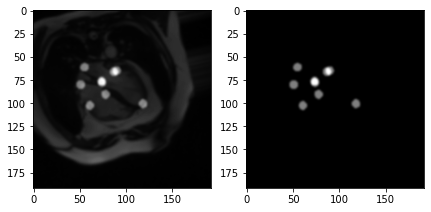

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.2578125  0.28125
 0.296875   0.3125     0.33203125 0.34765625 0.36328125 0.41015625
 0.4140625  0.50390625 0.55078125 0.5546875  0.56640625 0.5703125
 0.5859375  0.62890625 0.6328125  0.640625   0.6640625  0.6875
 0.7265625  0.7421875  0.8203125  0.8359375  0.85546875 0.859375
 0.86328125 0.90625    0.91796875 0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.6328125  0.6640625  0.6875     0.7421875  0.8203125  0.8359375
 0.85546875 0.859375   0.921875   0.9375     0.94140625 0.96484375
 0.98046875 0.99609

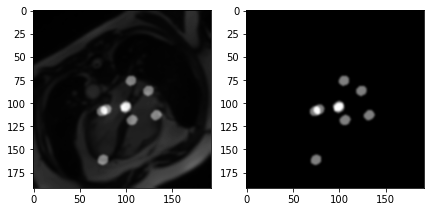

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.28125    0.296875   0.3125
 0.34765625 0.41015625 0.50390625 0.5546875  0.5703125  0.62890625
 0.640625   0.6640625  0.6875     0.7265625  0.8359375  0.859375
 0.90625    0.91796875 0.921875   0.9375     0.96484375 0.98046875
 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.28125    0.296875   0.3125
 0.34765625 0.41015625 0.50390625 0.5546875  0.5703125  0.62890625
 0.640625   0.6640625  0.6875     0.7265625  0.8359375  0.859375
 0.90625    0.91796875 0.921875   0.9375     0.96484375 0.98046875
 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234

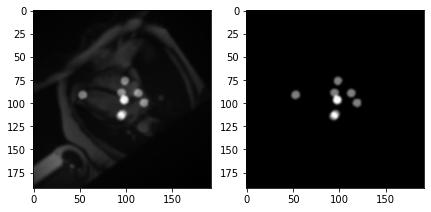

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.56640625
 0.5703125  0.6328125  0.640625   0.6640625  0.6875     0.7421875
 0.81640625 0.8203125  0.8359375  0.85546875 0.859375   0.90625
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.640625
 0.6640625  0.6875     0.7265625  0.7421875  0.81640625 0.8203125
 0.8359375  0.859375   0.90625    0.91796875 0.921875   0.9375
 0.94140625 0.96484375 0.98046875 0.9921875  0.9960937

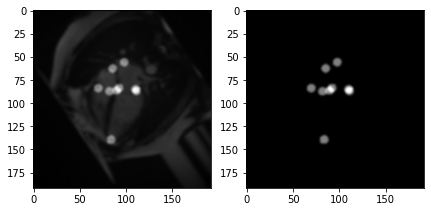

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.14453125 0.23046875 0.296875   0.3125
 0.34765625 0.36328125 0.5546875  0.62890625 0.6328125  0.6640625
 0.6875     0.8359375  0.85546875 0.921875   0.9375     0.96484375
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.23046875 0.234375
 0.25390625 0.28125    0.296875   0.3125     0.33203125 0.4140625
 0.55078125 0.56640625 0.5703125  0.640625   0.6640625  0.6875
 0.7421875  0.81640625 0.8203125  0.859375   0.90625    0.921875
 0.9375     0.94140625 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.0546875  0.05859375 0.0625     0.07421875 0.12109375
 0.125      0.13671875 0.15625    0.23046875 0.234375   0.25390625
 0.28125    0.296875   0.3125     0.3203125  0.33203125 0.390625
 0.40625    0.4140625  0.453125   0.55078125 0.5664062

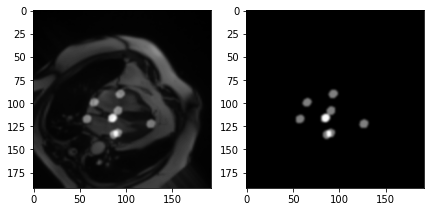

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21484375
 0.21875    0.23046875 0.234375   0.25390625 0.296875   0.3125
 0.33203125 0.34765625 0.4140625  0.53125    0.546875   0.55078125
 0.5546875  0.56640625 0.5703125  0.62890625 0.6640625  0.6875
 0.7421875  0.8203125  0.82421875 0.8359375  0.83984375 0.84375
 0.859375   0.921875   0.9375     0.94140625 0.9609375  0.96484375
 0.9765625  0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.4140625
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.6640625
 0.6875     0.7421875  0.81640625 0.8203125  0.8359375  0.859375
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625   

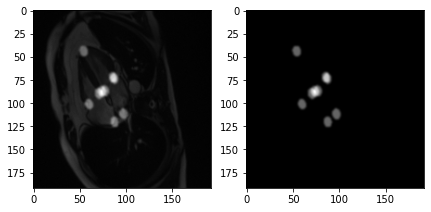

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.25390625 0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.41015625 0.4140625  0.50390625 0.5546875
 0.56640625 0.5703125  0.6328125  0.6640625  0.6875     0.7265625
 0.7421875  0.82421875 0.8359375  0.85546875 0.859375   0.91796875
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.07421875 0.12109375 0.13671875 0.140625
 0.14453125 0.21875    0.23046875 0.234375   0.25390625 0.296875
 0.3125     0.3203125  0.33203125 0.34765625 0.36328125 0.4140625
 0.4296875  0.546875   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.6328125  0.6640625  0.6796875  0.6875     0.7421875
 0.765625   0.8203125  0.8359375  0.83984375 0.84375    0.85546875
 0.859375   0.921875   0.92578125 0.9375     0.94140625 0.

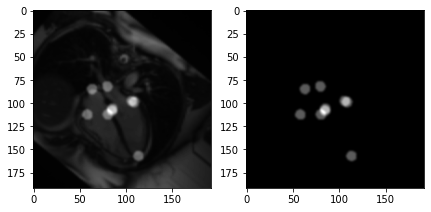

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.09765625 0.12109375 0.13671875
 0.14453125 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.28125    0.296875   0.3125     0.33203125 0.34765625 0.41015625
 0.4140625  0.50390625 0.546875   0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.640625   0.6640625  0.6875     0.7265625
 0.7421875  0.8203125  0.82421875 0.8359375  0.83984375 0.84375
 0.859375   0.90625    0.91796875 0.921875   0.9375     0.94140625
 0.96484375 0.9765625  0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.07421875 0.12109375 0.125
 0.14453125 0.15625    0.23046875 0.25390625 0.296875   0.3125
 0.3203125  0.33203125 0.34765625 0.390625   0.40625    0.453125
 0.55078125 0.5546875  0.5703125  0.62890625 0.6640625  0.6796875
 0.6875     0.7265625  0.75       0.78125    0.81640625 0.8359375
 0.83984375

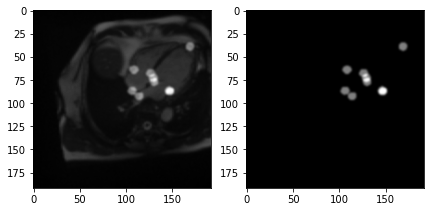

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.07421875 0.12109375 0.125
 0.14453125 0.15625    0.23046875 0.25390625 0.296875   0.3125
 0.3203125  0.33203125 0.34765625 0.36328125 0.390625   0.40625
 0.453125   0.55078125 0.5546875  0.5703125  0.62890625 0.6328125
 0.6640625  0.6796875  0.6875     0.7265625  0.75       0.78125
 0.81640625 0.8359375  0.83984375 0.85546875 0.921875   0.92578125
 0.9375     0.953125   0.9609375  0.96484375 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.34765625
 0.36328125 0.4140625  0.5546875  0.5703125  0.62890625 0.6328125
 0.640625   0.6640625  0.6875     0.7421875  0.8359375  0.83984375
 0.85546875 0.859375   0.90625    0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625

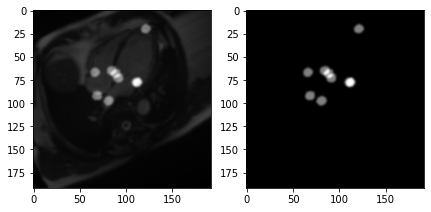

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.14453125 0.23046875 0.296875   0.3125
 0.34765625 0.5546875  0.62890625 0.6640625  0.6875     0.8359375
 0.921875   0.9375     0.96484375 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.296875   0.3125     0.34765625 0.41015625
 0.50390625 0.5546875  0.5703125  0.62890625 0.6640625  0.6875
 0.7265625  0.8359375  0.859375   0.91796875 0.921875   0.9375
 0.96484375 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.25390625 0.296875   0.3125     0.33203125
 0.34765625 0.41015625 0.4140625  0.50390625 0.55078125 0.5546875
 0.56640625 0.5703125  0.62890625 0.6640625  0.6875     0.7265625
 0.7421875  0.8203125  0.8359375  0.85937

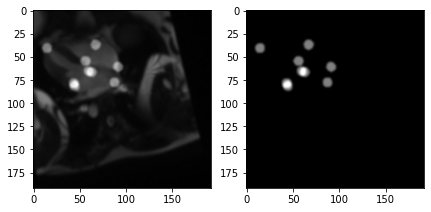

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.4140625  0.546875   0.55078125
 0.5546875  0.56640625 0.5703125  0.62890625 0.640625   0.6640625
 0.6875     0.7421875  0.8203125  0.8359375  0.84375    0.859375
 0.90625    0.921875   0.9375     0.94140625 0.96484375 0.9765625
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.33203125 0.34765625
 0.4140625  0.546875   0.55078125 0.5546875  0.56640625 0.62890625
 0.6640625  0.6875     0.7421875  0.8203125  0.8359375  0.84375
 0.921875   0.9375     0.94140625 0.96484375 0.9765625  0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.0

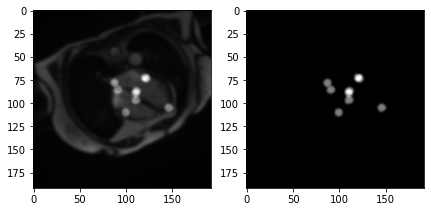

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.25390625 0.2578125  0.28125    0.296875
 0.33203125 0.34765625 0.36328125 0.41015625 0.4140625  0.50390625
 0.55078125 0.5546875  0.56640625 0.5703125  0.5859375  0.6328125
 0.640625   0.6640625  0.7265625  0.7421875  0.8203125  0.8359375
 0.83984375 0.85546875 0.859375   0.86328125 0.90625    0.91796875
 0.921875   0.94140625 0.96484375 0.98046875 0.9921875  0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.25390625 0.2578125  0.28125    0.296875
 0.33203125 0.34765625 0.36328125 0.41015625 0.4140625  0.50390625
 0.55078125 0.5546875  0.56640625 0.5703125  0.5859375  0.6328125
 0.640625   0.6640625  0.7265625  0.7421875  0.8203125  0.8359375
 0.83984375 0.85546875 0.859375   0.86328125 0.90625    0.9

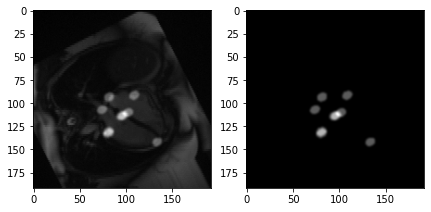

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.07421875 0.12109375 0.13671875 0.140625
 0.14453125 0.21875    0.23046875 0.234375   0.25390625 0.296875
 0.3125     0.3203125  0.33203125 0.34765625 0.4140625  0.4296875
 0.546875   0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.6640625  0.6796875  0.6875     0.7421875  0.765625   0.8203125
 0.8359375  0.83984375 0.84375    0.859375   0.921875   0.92578125
 0.9375     0.94140625 0.95703125 0.96484375 0.9765625  0.98046875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.09765625 0.12109375 0.13671875
 0.14453125 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.2578125  0.28125    0.296875   0.3125     0.34765625 0.41015625
 0.4140625  0.50390625 0.546875   0.5546875  0.5703125  0.5859375
 0.62890625 0.640625   0.6640625  0.6875     0.7265625  0.7421875
 0.8359375  0.83984375 0.84375    0.859375   0

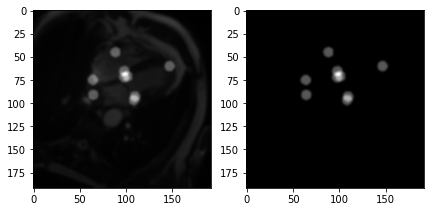

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.09765625 0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.234375   0.23828125 0.296875   0.34765625 0.41015625
 0.50390625 0.546875   0.5546875  0.5703125  0.62890625 0.6640625
 0.7265625  0.8359375  0.84375    0.859375   0.91796875 0.921875
 0.96484375 0.9765625  0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.21484375
 0.23046875 0.234375   0.23828125 0.29296875 0.296875   0.3125
 0.34765625 0.41015625 0.48828125 0.5546875  0.5703125  0.62890625
 0.6484375  0.6640625  0.6875     0.72265625 0.8359375  0.859375
 0.8984375  0.921875   0.9375     0.96484375 0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.21484375
 0.23046875 0.234375   0.23828125 0.29296875 0.296875   0.3125
 0.34765

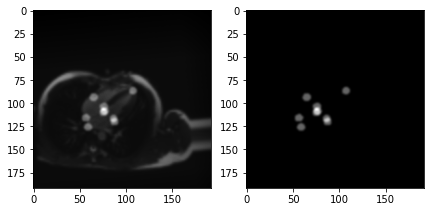

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.14453125 0.23046875 0.296875   0.3125
 0.34765625 0.36328125 0.5546875  0.6328125  0.6640625  0.6875
 0.8359375  0.85546875 0.921875   0.9375     0.96484375 0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.34765625 0.36328125
 0.4140625  0.546875   0.5546875  0.5703125  0.62890625 0.6328125
 0.6640625  0.6875     0.7421875  0.8359375  0.83984375 0.84375
 0.85546875 0.921875   0.9375     0.94140625 0.96484375 0.9765625
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.25390625 0.296875   0.3125     0.33203125
 0.34765625 0.41015625 0.4140625  0.50390625 0.55078125 0.5546875
 0.56640625 0.5703125  0.62890625 0.664062

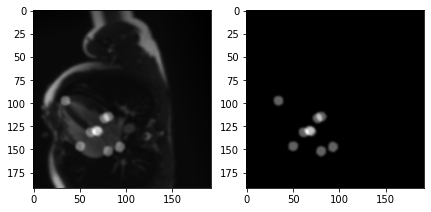

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21484375
 0.21875    0.23046875 0.234375   0.25390625 0.296875   0.3125
 0.33203125 0.34765625 0.36328125 0.4140625  0.53125    0.546875
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.6328125
 0.6640625  0.6875     0.7421875  0.8203125  0.8359375  0.84375
 0.85546875 0.859375   0.921875   0.9375     0.94140625 0.9609375
 0.96484375 0.9765625  0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.09765625 0.12109375 0.13671875
 0.14453125 0.21484375 0.21875    0.23046875 0.234375   0.23828125
 0.28125    0.296875   0.3125     0.34765625 0.36328125 0.41015625
 0.50390625 0.53125    0.546875   0.5546875  0.5703125  0.62890625
 0.6328125  0.640625   0.6640625  0.6875     0.7265625  0.8203125
 0.8359375  0.84375    0.85546875 0.859375   0.90625    0.91796875
 0.921875   0.937

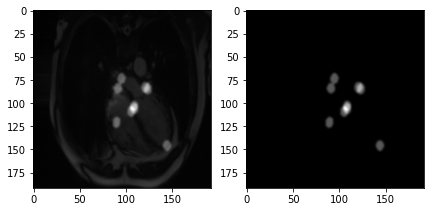

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.234375   0.25390625 0.2578125  0.28125    0.296875
 0.33203125 0.34765625 0.36328125 0.4140625  0.546875   0.55078125
 0.5546875  0.56640625 0.5703125  0.5859375  0.62890625 0.6328125
 0.640625   0.6640625  0.7421875  0.8203125  0.82421875 0.8359375
 0.83984375 0.84375    0.85546875 0.859375   0.86328125 0.90625
 0.921875   0.94140625 0.96484375 0.9765625  0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21484375 0.23046875 0.234375   0.23828125 0.25390625 0.2578125
 0.28125    0.29296875 0.296875   0.3125     0.33203125 0.34765625
 0.36328125 0.41015625 0.4140625  0.48828125 0.5546875  0.56640625
 0.5703125  0.5859375  0.62890625 0.6328125  0.640625   0.6484375
 0.6640625  0.6875     0.72265625 0.7421875  0.82421

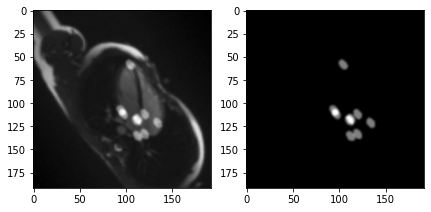

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21484375 0.21875    0.23046875 0.23828125 0.25390625 0.29296875
 0.296875   0.3125     0.33203125 0.34765625 0.36328125 0.41015625
 0.4140625  0.48828125 0.546875   0.55078125 0.5546875  0.5703125
 0.62890625 0.6328125  0.6484375  0.6640625  0.6875     0.72265625
 0.7421875  0.81640625 0.8359375  0.83984375 0.84375    0.85546875
 0.8984375  0.921875   0.9375     0.94140625 0.96484375 0.9765625
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.640625
 0.6640625  0.6875     0.7265625  0.7421875  0.81640625 0.82421875
 0.8359375  0.859375   0.90625    0.91796875 

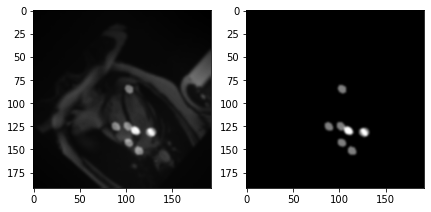

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.14453125 0.23046875 0.296875   0.3125
 0.33203125 0.34765625 0.55078125 0.5546875  0.62890625 0.6640625
 0.6875     0.81640625 0.8359375  0.921875   0.9375     0.96484375
 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.12109375 0.14453125 0.15625
 0.23046875 0.25390625 0.296875   0.3125     0.33203125 0.34765625
 0.390625   0.453125   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.6640625  0.6875     0.7265625  0.78125    0.8203125
 0.8359375  0.83984375 0.921875   0.9375     0.9609375  0.96484375
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.14453125 0.23046875 0.296875   0.3125
 0.33203125 0.34765625 0.55078125 0.5546875  0.62890625 0.6640625
 0.6875     0.81640625 0.8359375  0.921875   0.9375     0.96484375
 0.99609375 1.        ]
[0.  

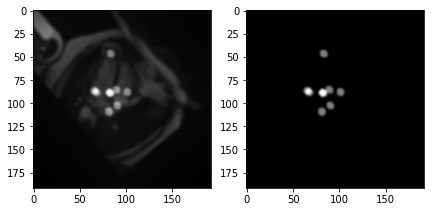

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21484375 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.29296875 0.296875   0.3125     0.34765625 0.41015625 0.4140625
 0.48828125 0.53125    0.546875   0.5546875  0.5703125  0.62890625
 0.6484375  0.6640625  0.6875     0.72265625 0.7421875  0.8203125
 0.8359375  0.83984375 0.84375    0.859375   0.8984375  0.921875
 0.9375     0.94140625 0.9609375  0.96484375 0.9765625  0.98046875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.09765625 0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.28125
 0.296875   0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.546875   0.5546875  0.56640625 0.5703125  0.62890625 0.640625
 0.6640625  0.7265625  0.7421875  0.82421875 0.8359375  0.83984375
 0.84375    0.859375   0.90625    0.91796875 0.

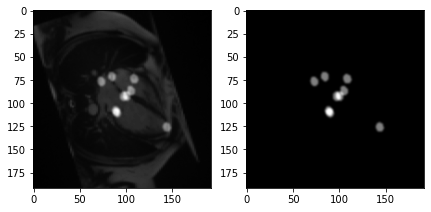

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.09765625 0.12109375 0.13671875
 0.14453125 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.28125    0.296875   0.3125     0.34765625 0.36328125 0.41015625
 0.4140625  0.50390625 0.546875   0.5546875  0.5703125  0.62890625
 0.6328125  0.640625   0.6640625  0.6875     0.7265625  0.7421875
 0.8359375  0.83984375 0.84375    0.85546875 0.859375   0.90625
 0.91796875 0.921875   0.9375     0.94140625 0.96484375 0.9765625
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.25390625 0.296875   0.3125     0.33203125
 0.34765625 0.41015625 0.4140625  0.50390625 0.55078125 0.5546875
 0.56640625 0.5703125  0.62890625 0.6640625  0.6875     0.7265625
 0.7421875  0.8203125  0.8359375  0.859375   0.91796875 0.921875
 0.9375     0.94140625 0.

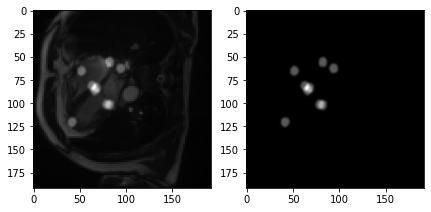

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.56640625
 0.5703125  0.6328125  0.640625   0.6640625  0.6875     0.7421875
 0.81640625 0.8203125  0.8359375  0.85546875 0.859375   0.90625
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.5546875  0.56640625 0.5703125  0.62890625
 0.640625   0.6640625  0.6875     0.7421875  0.82421875 0.8359375
 0.859375   0.90625    0.921875   0.9375     0.94140625 0.96484375
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875


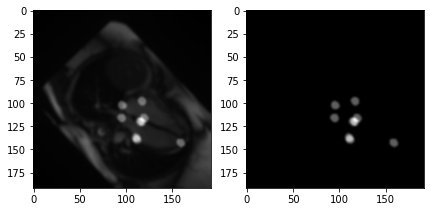

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.09765625 0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.23828125 0.296875   0.34765625 0.36328125 0.41015625 0.50390625
 0.5546875  0.5703125  0.6328125  0.6640625  0.7265625  0.8359375
 0.85546875 0.859375   0.91796875 0.921875   0.96484375 0.98046875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.234375   0.25390625 0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.546875   0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6640625  0.6875     0.7421875  0.8203125
 0.8359375  0.83984375 0.84375    0.859375   0.921875   0.9375
 0.94140625 0.96484375 0.9765625  0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.31

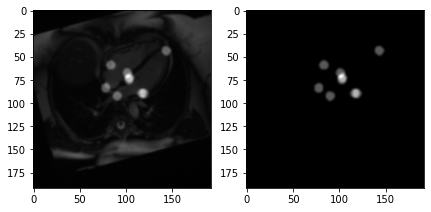

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.33203125 0.34765625
 0.4140625  0.546875   0.5546875  0.56640625 0.5703125  0.62890625
 0.6640625  0.6875     0.7421875  0.82421875 0.8359375  0.83984375
 0.84375    0.921875   0.9375     0.94140625 0.96484375 0.9765625
 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.0546875  0.05859375 0.0625     0.07421875 0.09765625
 0.12109375 0.125      0.13671875 0.15625    0.21484375 0.23046875
 0.234375   0.23828125 0.25390625 0.28125    0.296875   0.3125
 0.31640625 0.3203125  0.33203125 0.40625    0.41015625 0.4140625
 0.453125   0.48828125 0.50390625 0.55078125 0.56640625 0.5703125
 0.640625   0.6640625  0.6796875  0.6875     0.72265625 0.7265625
 0.7421875  0.75       0.78125    0.8203125  0.859375   0.90234375
 0.90625    0.91796875 0.921875   0.92578125 0.93

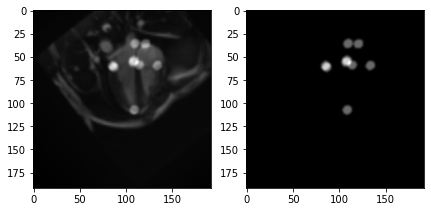

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.07421875 0.12109375 0.13671875 0.140625
 0.14453125 0.21875    0.23046875 0.234375   0.25390625 0.296875
 0.3125     0.3203125  0.33203125 0.34765625 0.36328125 0.4140625
 0.4296875  0.546875   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.6328125  0.6640625  0.6796875  0.6875     0.7421875
 0.765625   0.8203125  0.8359375  0.83984375 0.84375    0.85546875
 0.859375   0.921875   0.92578125 0.9375     0.94140625 0.95703125
 0.96484375 0.9765625  0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.07421875 0.12109375 0.13671875 0.140625
 0.14453125 0.21875    0.23046875 0.234375   0.25390625 0.28125
 0.296875   0.3203125  0.33203125 0.34765625 0.4140625  0.4296875
 0.546875   0.55078125 0.56640625 0.5703125  0.62890625 0.640625
 0.6640625  0.6796875  0.7421875  0.765625   0.8203125  0.82421875
 0.83984375 0.84375 

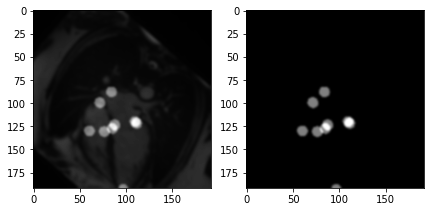

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.296875   0.3125     0.34765625 0.36328125
 0.41015625 0.50390625 0.5546875  0.5703125  0.62890625 0.6328125
 0.6640625  0.6875     0.7265625  0.8359375  0.85546875 0.859375
 0.91796875 0.921875   0.9375     0.96484375 0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.07421875 0.12109375 0.125
 0.13671875 0.14453125 0.15625    0.23046875 0.234375   0.25390625
 0.296875   0.3125     0.3203125  0.34765625 0.36328125 0.40625
 0.4140625  0.453125   0.5546875  0.5703125  0.62890625 0.6328125
 0.6640625  0.6796875  0.6875     0.7421875  0.75       0.78125
 0.8359375  0.83984375 0.85546875 0.859375   0.921875   0.92578125
 0.9375     0.94140625 0.953125   0.9609375  0.96484375 0.98046875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.0351

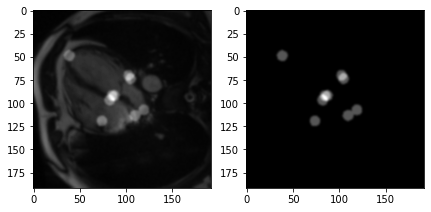

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6328125  0.640625   0.6640625  0.6875
 0.7421875  0.8203125  0.82421875 0.8359375  0.83984375 0.85546875
 0.859375   0.90625    0.921875   0.9375     0.94140625 0.96484375
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.640625   0.6640625  0.6875     0.7421875  0.8203125
 0.82421875 0.8359375  0.859375   0.90625    0.921875   0.9375
 0.94140625 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01

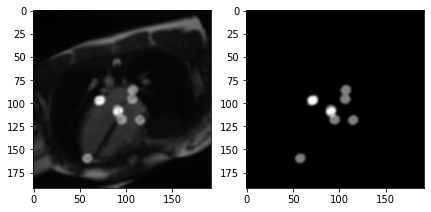

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.34765625 0.36328125 0.41015625 0.4140625  0.50390625
 0.5546875  0.5703125  0.62890625 0.6328125  0.640625   0.6640625
 0.6875     0.7265625  0.7421875  0.8359375  0.83984375 0.85546875
 0.859375   0.90625    0.91796875 0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.25390625 0.296875   0.3125     0.33203125
 0.34765625 0.41015625 0.4140625  0.50390625 0.55078125 0.5546875
 0.56640625 0.5703125  0.62890625 0.6640625  0.6875     0.7265625
 0.7421875  0.8203125  0.8359375  0.859375   0.91796875 0.921875
 0.9375     0.94140625 0.96484375 0.98046875 0.99609375 1.        ]
[0.         

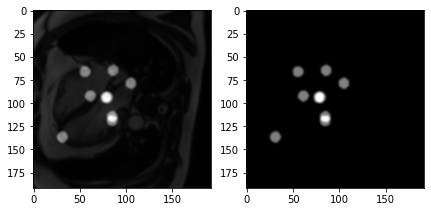

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.07421875 0.12109375 0.13671875
 0.140625   0.14453125 0.21875    0.23046875 0.234375   0.25390625
 0.28125    0.296875   0.3125     0.3203125  0.33203125 0.34765625
 0.4140625  0.4296875  0.546875   0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.640625   0.6640625  0.6796875  0.6875
 0.7421875  0.765625   0.8203125  0.8359375  0.83984375 0.84375
 0.859375   0.90625    0.921875   0.92578125 0.9375     0.94140625
 0.95703125 0.96484375 0.9765625  0.98046875 0.9921875  0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.640625
 0.6640625  0.6875     0.7265625  0.7421875  0.81640625 0.820

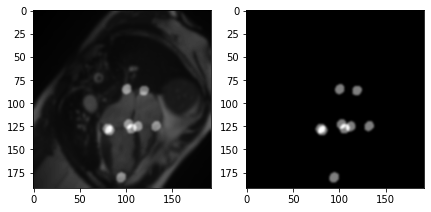

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.34765625 0.36328125 0.41015625 0.4140625  0.50390625
 0.5546875  0.5703125  0.62890625 0.6328125  0.640625   0.6640625
 0.6875     0.7265625  0.7421875  0.8359375  0.83984375 0.85546875
 0.859375   0.90625    0.91796875 0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.21484375
 0.23046875 0.234375   0.23828125 0.29296875 0.296875   0.3125
 0.34765625 0.41015625 0.48828125 0.5546875  0.5703125  0.62890625
 0.6484375  0.6640625  0.6875     0.72265625 0.8359375  0.859375
 0.8984375  0.921875   0.9375     0.96484375 0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0

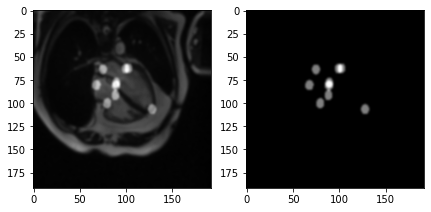

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.14453125 0.23046875 0.296875   0.3125
 0.33203125 0.34765625 0.36328125 0.55078125 0.5546875  0.6328125
 0.6640625  0.6875     0.81640625 0.8359375  0.85546875 0.921875
 0.9375     0.96484375 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.0546875  0.05859375 0.0625     0.07421875 0.12109375
 0.125      0.13671875 0.14453125 0.15625    0.23046875 0.234375
 0.25390625 0.28125    0.296875   0.3125     0.3203125  0.33203125
 0.34765625 0.390625   0.40625    0.4140625  0.453125   0.55078125
 0.5546875  0.56640625 0.5703125  0.62890625 0.640625   0.6640625
 0.6796875  0.6875     0.7265625  0.7421875  0.75       0.78125
 0.81640625 0.82421875 0.8359375  0.83984375 0.859375   0.90625
 0.921875   0.92578125 0.9375     0.94140625 0.953125   0.9609375
 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.0351562

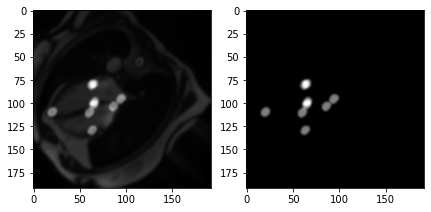

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.21484375
 0.23046875 0.234375   0.23828125 0.25390625 0.29296875 0.296875
 0.3125     0.34765625 0.36328125 0.41015625 0.4140625  0.48828125
 0.5546875  0.5703125  0.62890625 0.6328125  0.6484375  0.6640625
 0.6875     0.72265625 0.7421875  0.8359375  0.83984375 0.85546875
 0.859375   0.8984375  0.921875   0.9375     0.94140625 0.96484375
 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.05859375 0.0625     0.07421875 0.09765625
 0.12109375 0.125      0.13671875 0.14453125 0.15625    0.21875
 0.23046875 0.234375   0.23828125 0.25390625 0.296875   0.3125
 0.3203125  0.33203125 0.34765625 0.40625    0.41015625 0.4140625
 0.453125   0.50390625 0.546875   0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6640625  0.6796875  0.6875     0.7265625
 0.7421875  0.75       0.78125    0.816

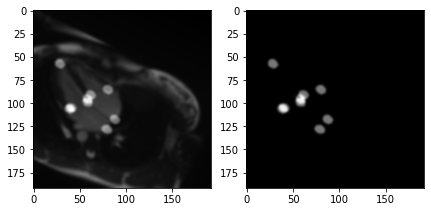

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.12109375 0.13671875 0.14453125
 0.15625    0.23046875 0.234375   0.25390625 0.296875   0.3125
 0.33203125 0.34765625 0.390625   0.4140625  0.453125   0.55078125
 0.5546875  0.56640625 0.5703125  0.62890625 0.6640625  0.6875
 0.7265625  0.7421875  0.78125    0.8203125  0.8359375  0.83984375
 0.859375   0.921875   0.9375     0.94140625 0.9609375  0.96484375
 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.05859375 0.0625     0.07421875 0.12109375
 0.125      0.13671875 0.14453125 0.15625    0.21875    0.23046875
 0.25390625 0.296875   0.3125     0.3203125  0.33203125 0.34765625
 0.40625    0.4140625  0.453125   0.546875   0.55078125 0.5546875
 0.56640625 0.5703125  0.62890625 0.6640625  0.6796875  0.6875
 0.7421875  0.75       0.78125    0.81640625 0.8203125  0.8359375
 0.83984375 0.84375    0.921875   0.92578

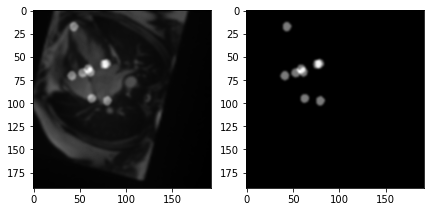

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.6328125  0.6640625  0.6875     0.7421875  0.8203125  0.8359375
 0.85546875 0.859375   0.921875   0.9375     0.94140625 0.96484375
 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.0546875  0.05859375 0.07421875 0.12109375
 0.125      0.13671875 0.140625   0.14453125 0.15625    0.21875
 0.23046875 0.234375   0.25390625 0.28125    0.296875   0.3203125
 0.33203125 0.34765625 0.40625    0.4140625  0.4296875  0.453125
 0.546875   0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.640625   0.6640625  0.6796875  0.7421875  0.75       0.765625
 0.78125    0.8203125  0.8359375  0.83984375 0.84375    0.859375
 0.90625    0.921875   0.92578125 0.9414

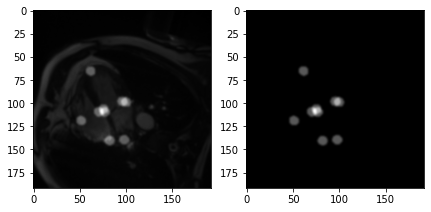

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.6328125  0.6640625  0.6875     0.7421875  0.8203125  0.8359375
 0.83984375 0.85546875 0.859375   0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.4140625
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.6640625
 0.6875     0.7421875  0.81640625 0.8203125  0.8359375  0.859375
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.07421875 0.12109375 0.13671875
 0.140625   

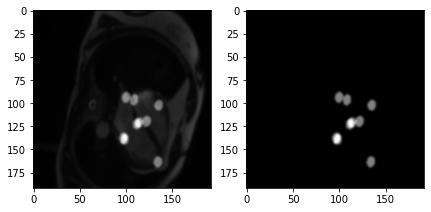

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.07421875 0.12109375 0.13671875 0.140625
 0.14453125 0.21875    0.23046875 0.234375   0.25390625 0.296875
 0.3125     0.3203125  0.33203125 0.34765625 0.4140625  0.4296875
 0.546875   0.5546875  0.56640625 0.5703125  0.62890625 0.6640625
 0.6796875  0.6875     0.7421875  0.765625   0.82421875 0.8359375
 0.83984375 0.84375    0.859375   0.921875   0.92578125 0.9375
 0.94140625 0.95703125 0.96484375 0.9765625  0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.6328125  0.6640625  0.6875     0.7421875  0.8203125  0.8359375
 0.85546875 0.859375   0.921875   0.9375     0.94140625 0.96484375
 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.019

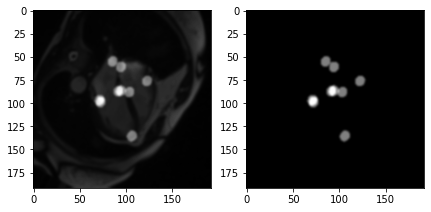

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.33203125 0.34765625
 0.4140625  0.546875   0.55078125 0.5546875  0.56640625 0.62890625
 0.6640625  0.6875     0.7421875  0.8203125  0.82421875 0.8359375
 0.84375    0.921875   0.9375     0.94140625 0.96484375 0.9765625
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.28125    0.296875   0.3125
 0.34765625 0.41015625 0.50390625 0.5546875  0.5703125  0.62890625
 0.640625   0.6640625  0.6875     0.7265625  0.8359375  0.859375
 0.90625    0.91796875 0.921875   0.9375     0.96484375 0.98046875
 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.2539

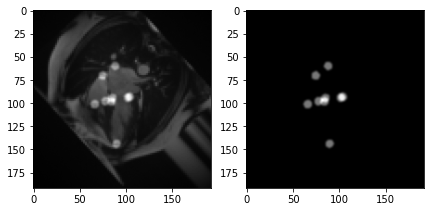

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21484375 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.29296875 0.296875   0.3125     0.33203125 0.34765625 0.41015625
 0.4140625  0.48828125 0.546875   0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6484375  0.6640625  0.6875     0.72265625
 0.7421875  0.8203125  0.8359375  0.84375    0.859375   0.8984375
 0.921875   0.9375     0.94140625 0.96484375 0.9765625  0.98046875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.09765625 0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.28125
 0.296875   0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.546875   0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.640625   0.6640625  0.7265625  0.7421875  0.8203125  0.8359375
 0.83984375 0.84375    0.859375   0.90625  

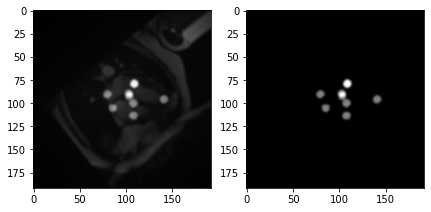

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.0546875  0.05859375 0.09765625 0.12109375 0.13671875
 0.14453125 0.15625    0.23046875 0.234375   0.23828125 0.25390625
 0.28125    0.34765625 0.390625   0.41015625 0.453125   0.50390625
 0.5546875  0.5703125  0.62890625 0.640625   0.7265625  0.78125
 0.8359375  0.83984375 0.859375   0.90625    0.91796875 0.9375
 0.9609375  0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.09765625 0.12109375 0.13671875 0.14453125
 0.21484375 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.28125    0.296875   0.33203125 0.34765625 0.36328125 0.41015625
 0.4140625  0.50390625 0.53125    0.546875   0.55078125 0.5546875
 0.56640625 0.5703125  0.6328125  0.640625   0.6640625  0.7265625
 0.7421875  0.8203125  0.82421875 0.8359375  0.84375    0.85546875
 0.859375   0.90625    0.91796875 0.921875   0.94140625 0.9609375
 0.9

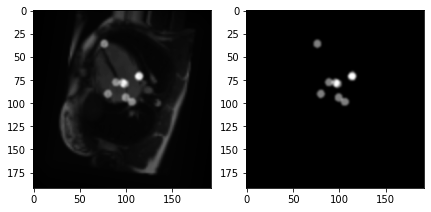

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.07421875 0.09765625 0.12109375 0.13671875
 0.140625   0.14453125 0.21875    0.23046875 0.234375   0.23828125
 0.25390625 0.296875   0.3125     0.3203125  0.33203125 0.34765625
 0.36328125 0.41015625 0.4140625  0.4296875  0.50390625 0.546875
 0.55078125 0.5546875  0.56640625 0.5703125  0.6328125  0.6640625
 0.6796875  0.6875     0.7265625  0.7421875  0.765625   0.81640625
 0.8203125  0.8359375  0.84375    0.85546875 0.859375   0.91796875
 0.921875   0.92578125 0.9375     0.94140625 0.95703125 0.96484375
 0.9765625  0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21484375 0.23046875 0.234375   0.23828125 0.25390625 0.28125
 0.29296875 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.41015625 0.4140625  0.48828125 0.55078125 0.5546875  0.56640625
 0.5703125  0.6328125  

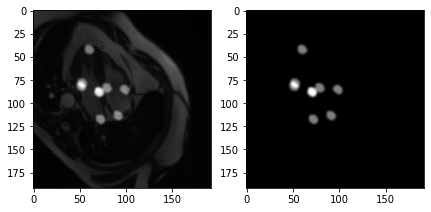

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.4140625
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.6640625
 0.6875     0.7421875  0.8203125  0.8359375  0.83984375 0.859375
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.23046875
 0.234375   0.23828125 0.25390625 0.28125    0.296875   0.3125
 0.33203125 0.41015625 0.4140625  0.50390625 0.55078125 0.56640625
 0.5703125  0.640625   0.6640625  0.6875     0.7265625  0.7421875
 0.8203125  0.82421875 0.859375   0.90625    0.91796875 0.921875
 0.9375     0.94140625 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453

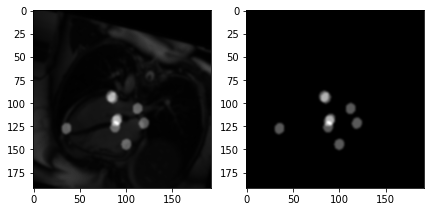

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.33203125 0.34765625
 0.4140625  0.546875   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.6640625  0.6875     0.7421875  0.8203125  0.8359375
 0.83984375 0.84375    0.921875   0.9375     0.94140625 0.96484375
 0.9765625  0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.07421875 0.09765625 0.12109375
 0.125      0.13671875 0.14453125 0.15625    0.21484375 0.23046875
 0.234375   0.23828125 0.296875   0.3125     0.31640625 0.3203125
 0.34765625 0.36328125 0.40625    0.41015625 0.453125   0.48828125
 0.5546875  0.5703125  0.62890625 0.6328125  0.6640625  0.6796875
 0.6875     0.72265625 0.75       0.78125    0.8359375  0.85546875
 0.859375   0.90234375 0.921875   0.92578125 0.9375     0.953125
 0.9609375  0.96484375 0.98046875 0.

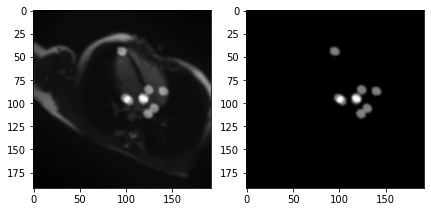

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.640625   0.6640625  0.6875     0.7421875  0.8203125
 0.8359375  0.83984375 0.859375   0.90625    0.921875   0.9375
 0.94140625 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.5546875  0.56640625 0.5703125
 0.62890625 0.6328125  0.640625   0.6640625  0.6875     0.7421875
 0.82421875 0.8359375  0.83984375 0.85546875 0.859375   0.90625
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390

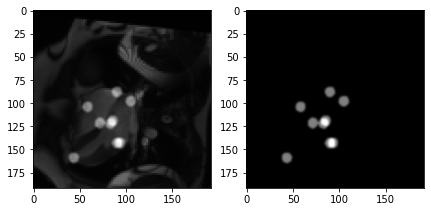

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.21484375
 0.23046875 0.234375   0.23828125 0.29296875 0.296875   0.3125
 0.34765625 0.36328125 0.41015625 0.48828125 0.5546875  0.5703125
 0.62890625 0.6328125  0.6484375  0.6640625  0.6875     0.72265625
 0.8359375  0.85546875 0.859375   0.8984375  0.921875   0.9375
 0.96484375 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.296875   0.3125     0.33203125 0.34765625
 0.41015625 0.50390625 0.55078125 0.5546875  0.5703125  0.62890625
 0.6640625  0.6875     0.7265625  0.81640625 0.8359375  0.859375
 0.91796875 0.921875   0.9375     0.96484375 0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.21484375
 0.23046875 0.

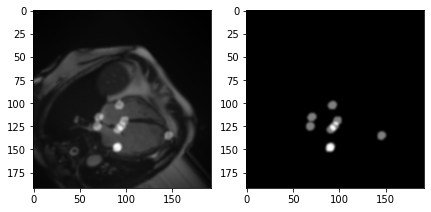

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.34765625 0.36328125
 0.4140625  0.546875   0.5546875  0.5703125  0.62890625 0.6328125
 0.6640625  0.6875     0.7421875  0.8359375  0.83984375 0.84375
 0.85546875 0.921875   0.9375     0.94140625 0.96484375 0.9765625
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.34765625 0.36328125
 0.4140625  0.546875   0.5546875  0.5703125  0.62890625 0.6328125
 0.6640625  0.6875     0.7421875  0.8359375  0.83984375 0.84375
 0.85546875 0.921875   0.9375     0.94140625 0.96484375 0.9765625
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.29687

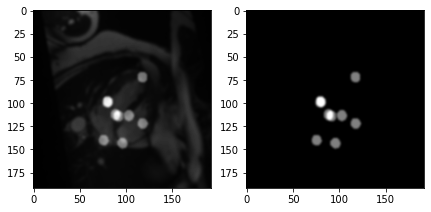

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.0546875  0.05859375 0.0625     0.07421875
 0.12109375 0.125      0.13671875 0.14453125 0.15625    0.21484375
 0.21875    0.23046875 0.234375   0.25390625 0.28125    0.296875
 0.3125     0.3203125  0.33203125 0.34765625 0.390625   0.40625
 0.4140625  0.453125   0.53125    0.546875   0.55078125 0.5546875
 0.56640625 0.5703125  0.62890625 0.640625   0.6640625  0.6796875
 0.6875     0.7265625  0.7421875  0.75       0.78125    0.81640625
 0.8203125  0.82421875 0.8359375  0.83984375 0.84375    0.859375
 0.90625    0.921875   0.92578125 0.9375     0.94140625 0.953125
 0.9609375  0.96484375 0.9765625  0.98046875 0.9921875  0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.4140625
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.66406

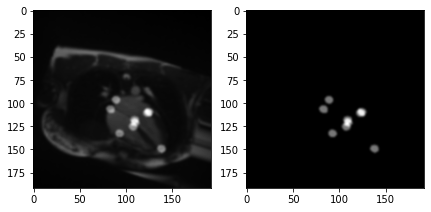

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.0546875  0.05859375 0.07421875 0.12109375 0.125
 0.13671875 0.14453125 0.15625    0.23046875 0.234375   0.25390625
 0.28125    0.296875   0.3203125  0.34765625 0.40625    0.4140625
 0.453125   0.5546875  0.5703125  0.62890625 0.640625   0.6640625
 0.6796875  0.7421875  0.75       0.78125    0.8359375  0.83984375
 0.859375   0.90625    0.921875   0.92578125 0.94140625 0.953125
 0.9609375  0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21484375 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.296875   0.3125     0.33203125 0.34765625 0.36328125 0.41015625
 0.4140625  0.50390625 0.53125    0.546875   0.5546875  0.56640625
 0.5703125  0.62890625 0.6328125  0.6640625  0.6875     0.7265625
 0.7421875  0.8203125  0.82421875 0.8359375  0.83984375 0.84375
 0.8554

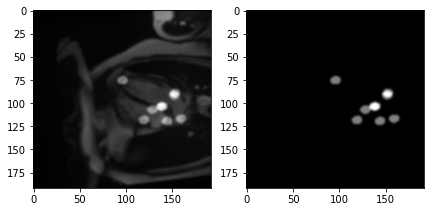

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.09765625 0.12109375 0.13671875
 0.14453125 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.28125    0.296875   0.3125     0.33203125 0.34765625 0.41015625
 0.4140625  0.50390625 0.546875   0.5546875  0.56640625 0.5703125
 0.62890625 0.640625   0.6640625  0.6875     0.7265625  0.7421875
 0.82421875 0.8359375  0.83984375 0.84375    0.859375   0.90625
 0.91796875 0.921875   0.9375     0.94140625 0.96484375 0.9765625
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.6328125  0.6640625  0.6875     0.7421875  0.8203125  0.8359375
 0.85546875 0.859375   0.921875   0.9375     0.94140625 0.96484375
 0.98046875 0.99609375 1.

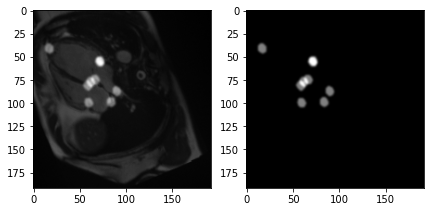

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.0546875  0.05859375 0.0625     0.12109375 0.13671875
 0.14453125 0.15625    0.23046875 0.234375   0.25390625 0.28125
 0.296875   0.3125     0.33203125 0.34765625 0.390625   0.4140625
 0.453125   0.5546875  0.56640625 0.5703125  0.62890625 0.640625
 0.6640625  0.6875     0.7265625  0.7421875  0.78125    0.82421875
 0.8359375  0.83984375 0.859375   0.90625    0.921875   0.9375
 0.94140625 0.9609375  0.96484375 0.98046875 0.9921875  0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.33203125 0.34765625
 0.4140625  0.546875   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.6640625  0.6875     0.7421875  0.81640625 0.8203125
 0.8359375  0.83984375 0.84375    0.921875   0.9375     0.94140625
 0.96484375 0.9765625  0.99609375 1.        ]
[0.         0.0039

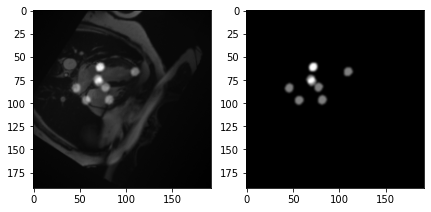

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.6328125  0.6640625  0.6875     0.7421875  0.8203125  0.8359375
 0.83984375 0.85546875 0.859375   0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.07421875 0.09765625 0.12109375 0.13671875
 0.140625   0.14453125 0.21875    0.23046875 0.234375   0.23828125
 0.25390625 0.296875   0.3125     0.3203125  0.34765625 0.41015625
 0.4140625  0.4296875  0.50390625 0.546875   0.5546875  0.5703125
 0.62890625 0.6640625  0.6796875  0.6875     0.7265625  0.7421875
 0.765625   0.8359375  0.83984375 0.84375    0.859375   0.91796875
 0.921875   0.92578125 0.9375     0.94140625 0.95703125 0.96484375
 0.9765625  0.9804687

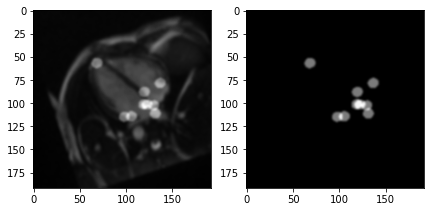

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.640625   0.6640625  0.6875     0.7421875  0.8203125
 0.8359375  0.83984375 0.859375   0.90625    0.921875   0.9375
 0.94140625 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.07421875 0.09765625 0.12109375
 0.13671875 0.140625   0.14453125 0.21875    0.23046875 0.234375
 0.23828125 0.25390625 0.28125    0.296875   0.3125     0.3203125
 0.33203125 0.34765625 0.36328125 0.41015625 0.4140625  0.4296875
 0.50390625 0.546875   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.6328125  0.640625   0.6640625  0.6796875  0.6875
 0.7265625  0.7421875  0.765625   0.8203125  0.8359375  0.84375
 0.85546875 0

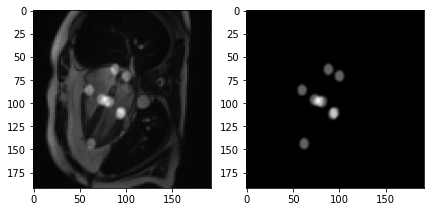

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.0546875  0.05859375 0.12109375 0.13671875 0.14453125
 0.15625    0.23046875 0.234375   0.25390625 0.28125    0.33203125
 0.34765625 0.36328125 0.390625   0.4140625  0.453125   0.5546875
 0.56640625 0.5703125  0.62890625 0.6328125  0.640625   0.7265625
 0.7421875  0.78125    0.82421875 0.8359375  0.83984375 0.85546875
 0.859375   0.90625    0.9375     0.94140625 0.9609375  0.96484375
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.14453125 0.23046875 0.296875   0.3125
 0.34765625 0.36328125 0.5546875  0.62890625 0.6328125  0.6640625
 0.6875     0.8359375  0.85546875 0.921875   0.9375     0.96484375
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0

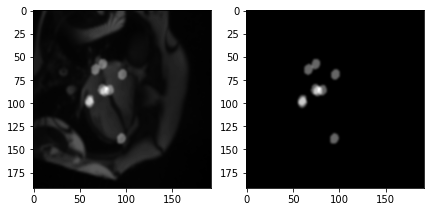

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21484375 0.23046875 0.234375   0.23828125 0.25390625 0.28125
 0.29296875 0.296875   0.3125     0.33203125 0.34765625 0.41015625
 0.4140625  0.48828125 0.5546875  0.56640625 0.5703125  0.62890625
 0.640625   0.6484375  0.6640625  0.6875     0.72265625 0.7421875
 0.82421875 0.8359375  0.83984375 0.859375   0.8984375  0.90625
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.14453125 0.23046875 0.296875   0.3125
 0.33203125 0.34765625 0.36328125 0.55078125 0.5546875  0.6328125
 0.6640625  0.6875     0.81640625 0.8359375  0.85546875 0.921875
 0.9375     0.96484375 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.09765625 0.12109375 0.13671875 0.14453125 0.21875
 0.23046875

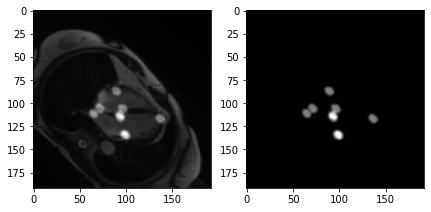

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.640625   0.6640625  0.6875     0.7421875  0.81640625
 0.82421875 0.8359375  0.859375   0.90625    0.921875   0.9375
 0.94140625 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.640625   0.6640625  0.6875     0.7421875  0.81640625
 0.82421875 0.8359375  0.83984375 0.859375   0.90625    0.921875
 0.9375     0.94140625 0.96484375 0.98046875 0.9921875  0.99609375
 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.

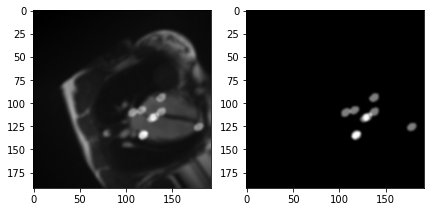

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.296875
 0.3125     0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.546875   0.5546875  0.56640625 0.5703125  0.62890625 0.6640625
 0.6875     0.7265625  0.7421875  0.82421875 0.8359375  0.83984375
 0.84375    0.859375   0.91796875 0.921875   0.9375     0.94140625
 0.96484375 0.9765625  0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.4140625  0.546875   0.55078125
 0.5546875  0.56640625 0.5703125  0.62890625 0.640625   0.6640625
 0.6875     0.7421875  0.8203125  0.82421875 0.8359375  0.83984375
 0.84375    0.859375   0.90625    0.921875   0.9375     0.94140625
 0.96484375

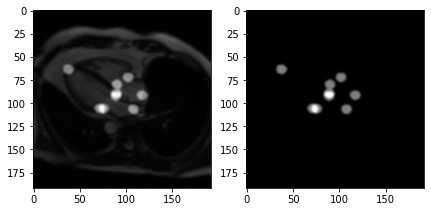

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.07421875 0.09765625 0.12109375
 0.125      0.13671875 0.14453125 0.15625    0.23046875 0.234375
 0.23828125 0.296875   0.3125     0.3203125  0.33203125 0.34765625
 0.40625    0.41015625 0.453125   0.50390625 0.55078125 0.5546875
 0.5703125  0.62890625 0.6640625  0.6796875  0.6875     0.7265625
 0.75       0.78125    0.81640625 0.8359375  0.859375   0.91796875
 0.921875   0.92578125 0.9375     0.953125   0.9609375  0.96484375
 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.09765625 0.12109375 0.13671875
 0.14453125 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.28125    0.296875   0.3125     0.34765625 0.36328125 0.41015625
 0.4140625  0.50390625 0.546875   0.5546875  0.5703125  0.62890625
 0.6328125  0.640625   0.6640625  0.6875     0.7265625  0.7421875
 0.8359375  0.83984375 0.84375  

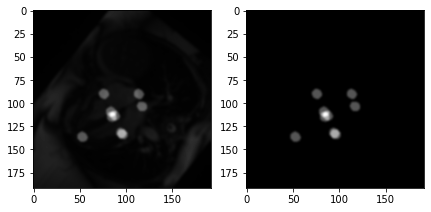

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.34765625 0.36328125 0.4140625
 0.5546875  0.5703125  0.62890625 0.6328125  0.6640625  0.6875
 0.7421875  0.8359375  0.83984375 0.85546875 0.859375   0.921875
 0.9375     0.94140625 0.96484375 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.12109375 0.13671875 0.14453125
 0.15625    0.23046875 0.234375   0.25390625 0.296875   0.3125
 0.33203125 0.34765625 0.36328125 0.390625   0.4140625  0.453125
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.6328125
 0.6640625  0.6875     0.7265625  0.7421875  0.78125    0.8203125
 0.8359375  0.83984375 0.85546875 0.859375   0.921875   0.9375
 0.94140625 0.9609375  0.96484375 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.

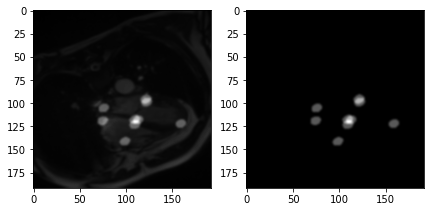

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.234375   0.25390625 0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.546875   0.5546875  0.56640625 0.5703125
 0.62890625 0.6640625  0.6875     0.7421875  0.82421875 0.8359375
 0.83984375 0.84375    0.859375   0.921875   0.9375     0.94140625
 0.96484375 0.9765625  0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.296875
 0.3125     0.34765625 0.41015625 0.4140625  0.50390625 0.546875
 0.5546875  0.5703125  0.62890625 0.6640625  0.6875     0.7265625
 0.7421875  0.8359375  0.83984375 0.84375    0.859375   0.91796875
 0.921875   0.9375     0.94140625 0.96484375 0.9765625  0.98046875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.

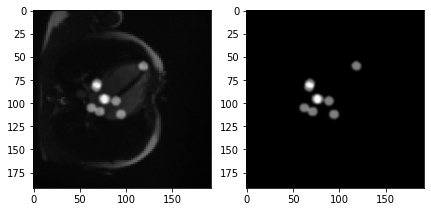

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.09765625 0.12109375 0.13671875
 0.14453125 0.21484375 0.21875    0.23046875 0.234375   0.23828125
 0.25390625 0.28125    0.29296875 0.296875   0.3125     0.33203125
 0.34765625 0.41015625 0.4140625  0.48828125 0.50390625 0.546875
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.640625
 0.6484375  0.6640625  0.6875     0.72265625 0.7265625  0.7421875
 0.8203125  0.8359375  0.83984375 0.84375    0.859375   0.8984375
 0.90625    0.91796875 0.921875   0.9375     0.94140625 0.96484375
 0.9765625  0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21484375 0.23046875 0.234375   0.23828125 0.25390625 0.28125
 0.29296875 0.296875   0.3125     0.33203125 0.34765625 0.41015625
 0.4140625  0.48828125 0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.64

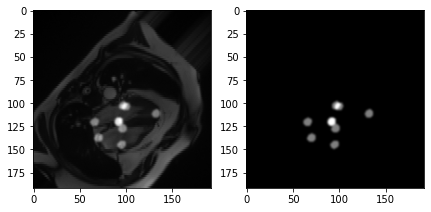

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.09765625 0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.28125
 0.296875   0.33203125 0.34765625 0.36328125 0.41015625 0.4140625
 0.50390625 0.546875   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.6328125  0.640625   0.6640625  0.7265625  0.7421875
 0.8203125  0.8359375  0.83984375 0.84375    0.85546875 0.859375
 0.90625    0.91796875 0.921875   0.94140625 0.96484375 0.9765625
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21484375 0.23046875 0.234375   0.23828125 0.25390625 0.28125
 0.29296875 0.296875   0.3125     0.33203125 0.34765625 0.41015625
 0.4140625  0.48828125 0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.640625   0.6484375  0.6640625  0.6875     0.72265625
 0.7421875  0.8203125  0.83593

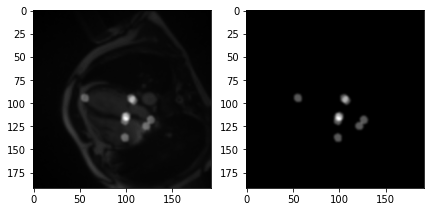

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.14453125 0.23046875 0.296875   0.3125
 0.34765625 0.5546875  0.62890625 0.6640625  0.6875     0.8359375
 0.921875   0.9375     0.96484375 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.07421875 0.12109375 0.125
 0.13671875 0.14453125 0.15625    0.23046875 0.234375   0.25390625
 0.296875   0.3125     0.3203125  0.33203125 0.34765625 0.36328125
 0.390625   0.40625    0.4140625  0.453125   0.55078125 0.5546875
 0.56640625 0.5703125  0.62890625 0.6328125  0.6640625  0.6796875
 0.6875     0.7265625  0.7421875  0.75       0.78125    0.8203125
 0.8359375  0.83984375 0.85546875 0.859375   0.921875   0.92578125
 0.9375     0.94140625 0.953125   0.9609375  0.96484375 0.98046875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.12109375 0.13671875 0.144

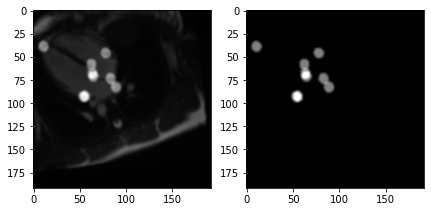

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.36328125 0.4140625  0.546875
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.6328125
 0.640625   0.6640625  0.6875     0.7421875  0.8203125  0.8359375
 0.83984375 0.84375    0.85546875 0.859375   0.90625    0.921875
 0.9375     0.94140625 0.96484375 0.9765625  0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625 0.640625
 0.6640625  0.6875     0.7265625  0.7421875  0.81640625 0.8203125
 0.8359375  0.859375   0.90625    0.91796875 0.921875

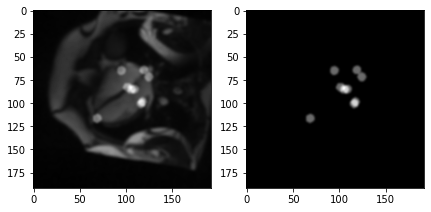

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.21484375
 0.23046875 0.234375   0.23828125 0.29296875 0.296875   0.3125
 0.34765625 0.41015625 0.48828125 0.5546875  0.5703125  0.62890625
 0.6484375  0.6640625  0.6875     0.72265625 0.8359375  0.859375
 0.8984375  0.921875   0.9375     0.96484375 0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.14453125 0.23046875 0.296875   0.3125
 0.34765625 0.5546875  0.62890625 0.6640625  0.6875     0.8359375
 0.921875   0.9375     0.96484375 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.640625   0.6640625  0.6875     0.7421875  0.81640625
 0.82

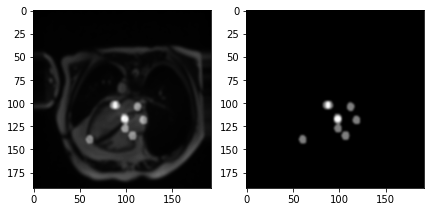

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.5546875  0.56640625 0.5703125  0.62890625 0.640625   0.6640625
 0.6875     0.7265625  0.7421875  0.82421875 0.8359375  0.83984375
 0.859375   0.90625    0.91796875 0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.5546875  0.56640625 0.5703125  0.62890625 0.640625   0.6640625
 0.6875     0.7265625  0.7421875  0.82421875 0.8359375  0.83984375
 0.859375   0.90625    0.91796875 0.921875   0.9375     0.94140625
 0.96484375 0

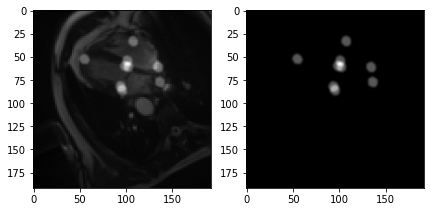

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6328125  0.640625   0.6640625  0.6875
 0.7421875  0.8203125  0.8359375  0.85546875 0.859375   0.90625
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.28125    0.296875   0.3125
 0.34765625 0.41015625 0.50390625 0.5546875  0.5703125  0.62890625
 0.640625   0.6640625  0.6875     0.7265625  0.8359375  0.859375
 0.90625    0.91796875 0.921875   0.9375     0.96484375 0.98046875
 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625  

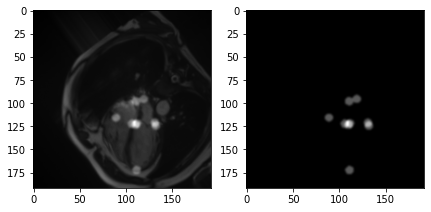

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.4140625  0.5546875  0.56640625 0.5703125  0.62890625 0.6328125
 0.6640625  0.6875     0.7421875  0.82421875 0.8359375  0.85546875
 0.859375   0.921875   0.9375     0.94140625 0.96484375 0.98046875
 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.05859375 0.0625     0.07421875 0.12109375
 0.125      0.13671875 0.140625   0.14453125 0.15625    0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.3203125  0.33203125
 0.34765625 0.36328125 0.390625   0.40625    0.4140625  0.4296875
 0.453125   0.546875   0.5546875  0.56640625 0.62890625 0.6328125
 0.6640625  0.6796875  0.6875     0.7265625  0.7421875  0.75
 0.765625   0.78125    0.82421875 0.8359375  0.84375    0.85546875
 0.921875   0.92578125 0.9375     0.94140625 0.95312

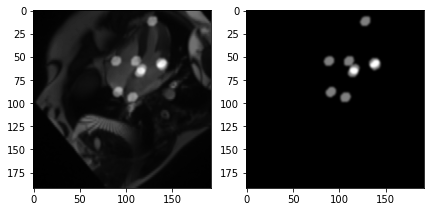

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.05859375 0.0625     0.07421875 0.12109375
 0.125      0.13671875 0.14453125 0.15625    0.21875    0.23046875
 0.25390625 0.296875   0.3125     0.3203125  0.33203125 0.34765625
 0.390625   0.40625    0.4140625  0.453125   0.546875   0.55078125
 0.5546875  0.56640625 0.5703125  0.62890625 0.6640625  0.6796875
 0.6875     0.7265625  0.7421875  0.75       0.78125    0.81640625
 0.82421875 0.8359375  0.83984375 0.84375    0.921875   0.92578125
 0.9375     0.94140625 0.953125   0.9609375  0.96484375 0.9765625
 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.05859375 0.0625     0.07421875 0.09765625
 0.12109375 0.125      0.13671875 0.14453125 0.15625    0.21484375
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.29296875
 0.296875   0.3125     0.3203125  0.33203125 0.34765625 0.390625
 0.40625    0.41015625 0.4140625  0.453125

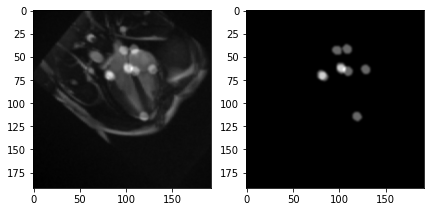

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.34765625 0.36328125 0.4140625
 0.5546875  0.5703125  0.62890625 0.6328125  0.6640625  0.6875
 0.7421875  0.8359375  0.83984375 0.85546875 0.859375   0.921875
 0.9375     0.94140625 0.96484375 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.21484375
 0.23046875 0.234375   0.23828125 0.25390625 0.29296875 0.296875
 0.3125     0.33203125 0.34765625 0.36328125 0.41015625 0.4140625
 0.48828125 0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.6328125  0.6484375  0.6640625  0.6875     0.72265625 0.7421875
 0.8203125  0.8359375  0.83984375 0.85546875 0.859375   0.8984375
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0585

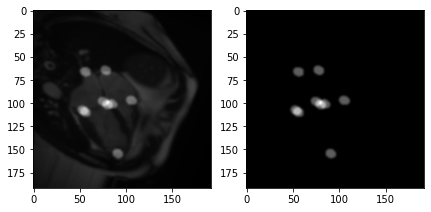

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.5546875  0.56640625 0.5703125  0.62890625 0.640625   0.6640625
 0.6875     0.7265625  0.7421875  0.82421875 0.8359375  0.859375
 0.90625    0.91796875 0.921875   0.9375     0.94140625 0.96484375
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6328125  0.640625   0.6640625  0.6875
 0.7421875  0.8203125  0.82421875 0.8359375  0.83984375 0.85546875
 0.859375   0.90625    0.921875   0.9375     0.94140625 0.96484375
 0.98046875 0.9921875  0.99

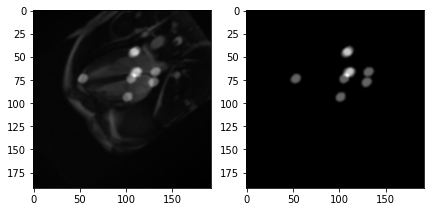

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.09765625 0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.28125
 0.296875   0.34765625 0.41015625 0.4140625  0.50390625 0.546875
 0.5546875  0.5703125  0.62890625 0.640625   0.6640625  0.7265625
 0.7421875  0.8359375  0.83984375 0.84375    0.859375   0.90625
 0.91796875 0.921875   0.94140625 0.96484375 0.9765625  0.98046875
 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6328125  0.640625   0.6640625  0.6875
 0.7421875  0.81640625 0.8203125  0.8359375  0.85546875 0.859375
 0.90625    0.921875   0.9375     0.94140625 0.96484375 0.98046875
 0.9921875  0.99609375 1.        ]
[0.     

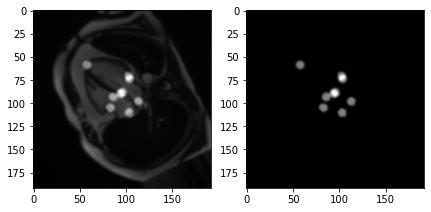

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.296875   0.3125     0.34765625 0.41015625
 0.50390625 0.5546875  0.5703125  0.62890625 0.6640625  0.6875
 0.7265625  0.8359375  0.859375   0.91796875 0.921875   0.9375
 0.96484375 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.07421875 0.12109375 0.125
 0.14453125 0.15625    0.23046875 0.25390625 0.296875   0.3125
 0.3203125  0.33203125 0.34765625 0.390625   0.40625    0.453125
 0.55078125 0.5546875  0.5703125  0.62890625 0.6640625  0.6796875
 0.6875     0.7265625  0.75       0.78125    0.81640625 0.8359375
 0.83984375 0.921875   0.92578125 0.9375     0.953125   0.9609375
 0.96484375 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.

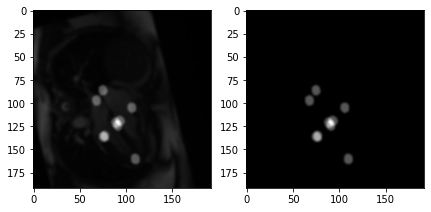

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.07421875 0.09765625 0.12109375
 0.125      0.13671875 0.14453125 0.15625    0.23046875 0.234375
 0.23828125 0.25390625 0.296875   0.3125     0.3203125  0.33203125
 0.34765625 0.36328125 0.40625    0.41015625 0.4140625  0.453125
 0.50390625 0.55078125 0.5546875  0.56640625 0.5703125  0.6328125
 0.6640625  0.6796875  0.6875     0.7265625  0.7421875  0.75
 0.78125    0.8203125  0.8359375  0.85546875 0.859375   0.91796875
 0.921875   0.92578125 0.9375     0.94140625 0.953125   0.9609375
 0.96484375 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.5546875  0.56640625 0.5703125
 0.62890625 0.6328125  0.640625   0.6640625  0.6875     0.7421875
 0.82421875 0.8359375  0.839843

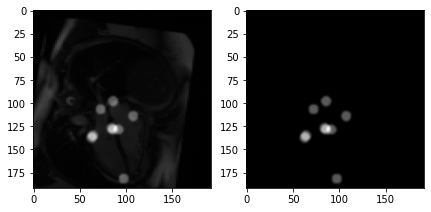

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.07421875 0.09765625 0.12109375
 0.125      0.13671875 0.14453125 0.15625    0.21484375 0.23046875
 0.234375   0.23828125 0.25390625 0.29296875 0.296875   0.3125
 0.3203125  0.33203125 0.34765625 0.390625   0.40625    0.41015625
 0.4140625  0.453125   0.48828125 0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6484375  0.6640625  0.6796875  0.6875
 0.72265625 0.7265625  0.7421875  0.75       0.78125    0.8203125
 0.82421875 0.8359375  0.83984375 0.859375   0.8984375  0.921875
 0.92578125 0.9375     0.94140625 0.953125   0.9609375  0.96484375
 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.234375   0.25390625 0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.546875   0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6640625  0.6875 

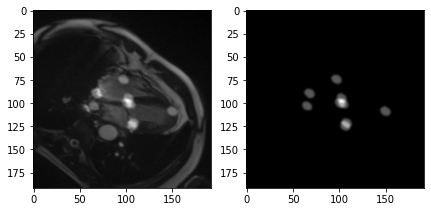

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.56640625
 0.5703125  0.6328125  0.640625   0.6640625  0.6875     0.7421875
 0.8203125  0.82421875 0.8359375  0.85546875 0.859375   0.90625
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.34765625
 0.36328125 0.4140625  0.5546875  0.5703125  0.62890625 0.6328125
 0.640625   0.6640625  0.6875     0.7421875  0.8359375  0.83984375
 0.85546875 0.859375   0.90625    0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 

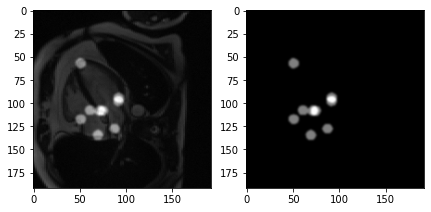

[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.05859375 0.0625     0.07421875 0.09765625
 0.12109375 0.125      0.13671875 0.14453125 0.15625    0.21875
 0.23046875 0.234375   0.23828125 0.25390625 0.296875   0.3125
 0.3203125  0.33203125 0.34765625 0.390625   0.40625    0.41015625
 0.4140625  0.453125   0.50390625 0.546875   0.55078125 0.5546875
 0.56640625 0.5703125  0.62890625 0.6640625  0.6796875  0.6875
 0.7265625  0.7421875  0.75       0.78125    0.8203125  0.8359375
 0.83984375 0.84375    0.859375   0.91796875 0.921875   0.92578125
 0.9375     0.94140625 0.953125   0.9609375  0.96484375 0.9765625
 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.4140625  0.5546875  0.56640625 0.5703125  0.62890625
 0.640625   0.6640625  0.6875     0.742187

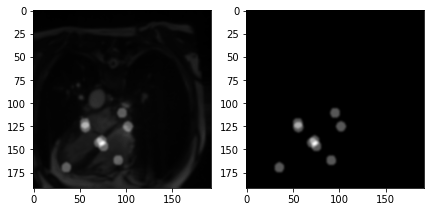

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6328125  0.640625   0.6640625  0.6875
 0.7421875  0.8203125  0.82421875 0.8359375  0.83984375 0.85546875
 0.859375   0.90625    0.921875   0.9375     0.94140625 0.96484375
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.6328125  0.6640625  0.6875     0.7421875  0.8203125  0.8359375
 0.83984375 0.85546875 0.859375   0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 

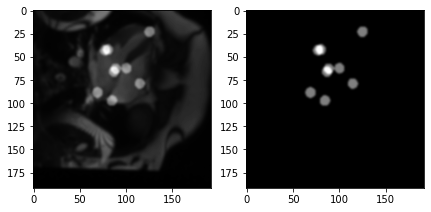

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.36328125 0.4140625  0.546875
 0.55078125 0.5546875  0.56640625 0.5703125  0.6328125  0.640625
 0.6640625  0.6875     0.7421875  0.8203125  0.82421875 0.8359375
 0.83984375 0.84375    0.85546875 0.859375   0.90625    0.921875
 0.9375     0.94140625 0.96484375 0.9765625  0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.25390625 0.296875   0.3125     0.34765625
 0.36328125 0.41015625 0.4140625  0.50390625 0.5546875  0.5703125
 0.62890625 0.6328125  0.6640625  0.6875     0.7265625  0.7421875
 0.8359375  0.83984375 0.85546875 0.859375   0.91796875 0.921875
 0.9375     0.94140625 0.96484375 0.98046875 0.99609

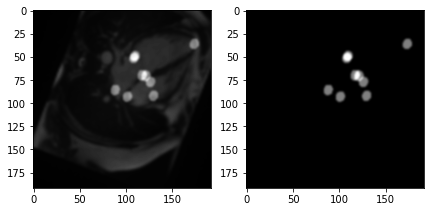

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.4140625  0.546875   0.5546875
 0.56640625 0.5703125  0.62890625 0.640625   0.6640625  0.6875
 0.7421875  0.82421875 0.8359375  0.83984375 0.84375    0.859375
 0.90625    0.921875   0.9375     0.94140625 0.96484375 0.9765625
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.296875
 0.3125     0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.546875   0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.6640625  0.6875     0.7265625  0.7421875  0.81640625 0.8203125
 0.8359375  0.83984375 0.84375    0.859375   0.91796875 0.921875
 0.9375     0.94140625 0.964843

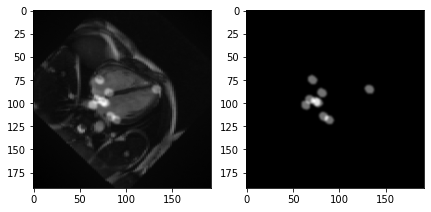

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.09765625 0.12109375 0.13671875
 0.14453125 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.28125    0.296875   0.3125     0.33203125 0.34765625 0.41015625
 0.4140625  0.50390625 0.546875   0.5546875  0.56640625 0.5703125
 0.62890625 0.640625   0.6640625  0.6875     0.7265625  0.7421875
 0.82421875 0.8359375  0.83984375 0.84375    0.859375   0.90625
 0.91796875 0.921875   0.9375     0.94140625 0.96484375 0.9765625
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.21484375
 0.23046875 0.234375   0.23828125 0.29296875 0.296875   0.3125
 0.34765625 0.36328125 0.41015625 0.48828125 0.50390625 0.5546875
 0.5703125  0.62890625 0.6328125  0.6484375  0.6640625  0.6875
 0.72265625 0.7265625  0.8359375  0.85546875 0.859375   0.8984375
 0.91796875 0.921875   0.9375   

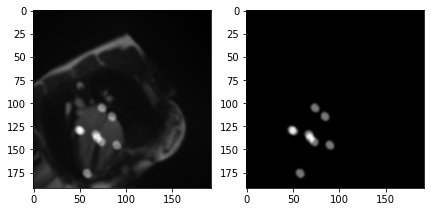

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21484375 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.29296875 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.41015625 0.4140625  0.48828125 0.50390625 0.53125    0.546875
 0.55078125 0.5546875  0.56640625 0.5703125  0.6328125  0.6484375
 0.6640625  0.6875     0.72265625 0.7265625  0.7421875  0.8203125
 0.8359375  0.84375    0.85546875 0.859375   0.8984375  0.91796875
 0.921875   0.9375     0.94140625 0.9609375  0.96484375 0.9765625
 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6328125  0.640625   0.6640625  0.6875
 0.7421875  0.8203125  0.8359375  0.8

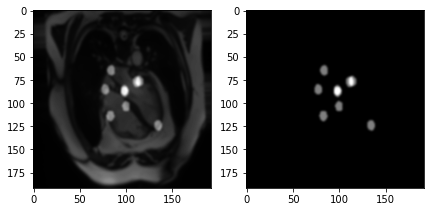

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.5703125
 0.62890625 0.6328125  0.640625   0.6640625  0.6875     0.7421875
 0.81640625 0.8359375  0.83984375 0.85546875 0.859375   0.90625
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6328125  0.640625   0.6640625  0.6875
 0.7421875  0.81640625 0.82421875 0.8359375  0.85546875 0.859375
 0.90625    0.921875   0.9375     0.94140625 0.96484375 0.98046875
 0.9921875  0.99609375 1.        ]
[0.         0.003

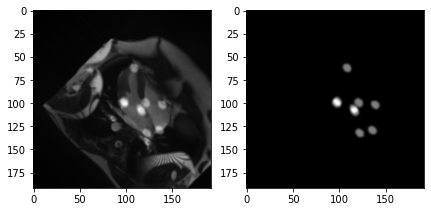

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.296875
 0.3125     0.33203125 0.34765625 0.41015625 0.4140625  0.50390625
 0.546875   0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.6640625  0.6875     0.7265625  0.7421875  0.81640625 0.8203125
 0.8359375  0.83984375 0.84375    0.859375   0.91796875 0.921875
 0.9375     0.94140625 0.96484375 0.9765625  0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.09765625 0.12109375 0.13671875 0.14453125
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.28125
 0.296875   0.33203125 0.34765625 0.36328125 0.41015625 0.4140625
 0.50390625 0.546875   0.55078125 0.5546875  0.56640625 0.5703125
 0.6328125  0.640625   0.6640625  0.7265625  0.7421875  0.8203125
 0.82421875 0.8359375  0.84375    0.85546875 0.859375   0.90

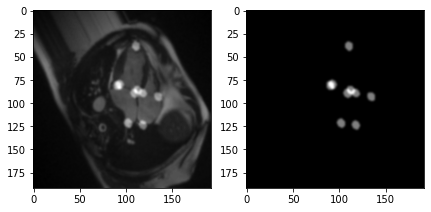

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.07421875 0.12109375 0.13671875
 0.140625   0.14453125 0.21875    0.23046875 0.234375   0.25390625
 0.28125    0.296875   0.3125     0.3203125  0.34765625 0.4140625
 0.4296875  0.546875   0.5546875  0.5703125  0.62890625 0.640625
 0.6640625  0.6796875  0.6875     0.7421875  0.765625   0.8359375
 0.83984375 0.84375    0.859375   0.90625    0.921875   0.92578125
 0.9375     0.94140625 0.95703125 0.96484375 0.9765625  0.98046875
 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21484375
 0.21875    0.23046875 0.234375   0.25390625 0.296875   0.3125
 0.33203125 0.34765625 0.4140625  0.53125    0.546875   0.55078125
 0.5546875  0.56640625 0.5703125  0.62890625 0.6640625  0.6875
 0.7421875  0.8203125  0.8359375  0.83984375 0.84375    0.859375
 0.921875   0.9375     0.94140625 0.96093

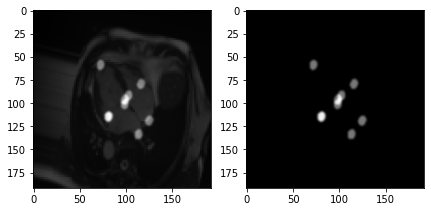

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.23046875 0.234375
 0.23828125 0.25390625 0.296875   0.3125     0.33203125 0.41015625
 0.4140625  0.50390625 0.55078125 0.56640625 0.5703125  0.6640625
 0.6875     0.7265625  0.7421875  0.81640625 0.8203125  0.859375
 0.91796875 0.921875   0.9375     0.94140625 0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.09765625 0.12109375 0.13671875
 0.14453125 0.21484375 0.21875    0.23046875 0.234375   0.23828125
 0.25390625 0.28125    0.29296875 0.296875   0.3125     0.33203125
 0.34765625 0.41015625 0.4140625  0.48828125 0.50390625 0.546875
 0.5546875  0.56640625 0.5703125  0.62890625 0.640625   0.6484375
 0.6640625  0.6875     0.72265625 0.7265625  0.7421875  0.82421875
 0.8359375  0.83984375 0.84375    0.859375   0.8984375  0.90625
 0.91796875 0.921875   0.9375     0.94140625 0.96484375 0.97

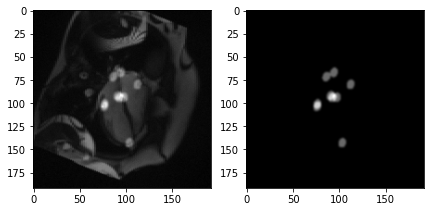

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.09765625 0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.23828125 0.296875   0.34765625 0.36328125 0.41015625 0.50390625
 0.5546875  0.5703125  0.6328125  0.6640625  0.7265625  0.8359375
 0.85546875 0.859375   0.91796875 0.921875   0.96484375 0.98046875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.23828125 0.25390625 0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.41015625 0.4140625  0.50390625 0.55078125
 0.5546875  0.56640625 0.5703125  0.6328125  0.6640625  0.6875
 0.7265625  0.7421875  0.8203125  0.8359375  0.85546875 0.859375
 0.91796875 0.921875   0.9375     0.94140625 0.96484375 0.98046875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.09765625 0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.23828125 0.296875   0.

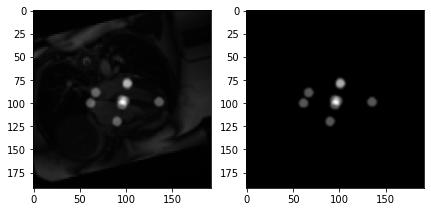

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.6328125  0.6640625  0.6875     0.7421875  0.8203125  0.8359375
 0.83984375 0.85546875 0.859375   0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.34765625
 0.36328125 0.4140625  0.5546875  0.5703125  0.62890625 0.6328125
 0.640625   0.6640625  0.6875     0.7421875  0.8359375  0.83984375
 0.85546875 0.859375   0.90625    0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.136718

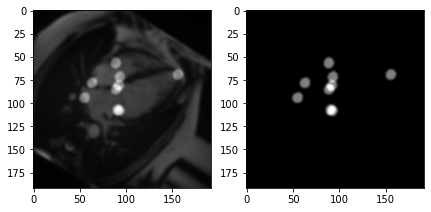

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.21484375
 0.23046875 0.234375   0.23828125 0.25390625 0.29296875 0.296875
 0.3125     0.33203125 0.34765625 0.36328125 0.41015625 0.4140625
 0.48828125 0.55078125 0.5546875  0.56640625 0.5703125  0.6328125
 0.6484375  0.6640625  0.6875     0.72265625 0.7421875  0.81640625
 0.8203125  0.8359375  0.85546875 0.859375   0.8984375  0.921875
 0.9375     0.94140625 0.96484375 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.0390625  0.04296875 0.05859375 0.0625     0.09765625 0.12109375
 0.13671875 0.14453125 0.15625    0.21875    0.23046875 0.234375
 0.23828125 0.25390625 0.2578125  0.296875   0.3125     0.33203125
 0.34765625 0.390625   0.41015625 0.4140625  0.453125   0.50390625
 0.546875   0.5546875  0.56640625 0.5703125  0.5859375  0.62890625
 0.6640625  0.6875     0.7265625  0.7421875  0.78125    0.82421875
 0

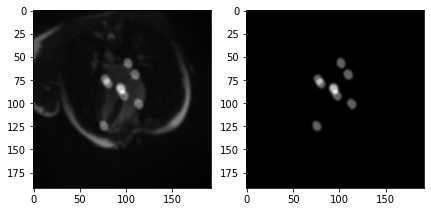

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125  0.6328125
 0.6640625  0.6875     0.7421875  0.8203125  0.82421875 0.8359375
 0.85546875 0.859375   0.921875   0.9375     0.94140625 0.96484375
 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.25390625 0.28125    0.296875
 0.3125     0.33203125 0.34765625 0.36328125 0.41015625 0.4140625
 0.50390625 0.5546875  0.56640625 0.5703125  0.62890625 0.6328125
 0.640625   0.6640625  0.6875     0.7265625  0.7421875  0.82421875
 0.8359375  0.83984375 0.85546875 0.859375   0.90625    0.91796875
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0

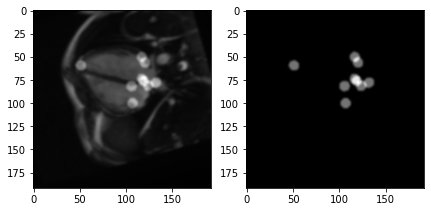

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.23046875 0.234375   0.23828125 0.28125    0.296875   0.3125
 0.34765625 0.41015625 0.50390625 0.5546875  0.5703125  0.62890625
 0.640625   0.6640625  0.6875     0.7265625  0.8359375  0.859375
 0.90625    0.91796875 0.921875   0.9375     0.96484375 0.98046875
 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.33203125 0.34765625
 0.4140625  0.546875   0.55078125 0.5546875  0.56640625 0.5703125
 0.62890625 0.6640625  0.6875     0.7421875  0.8203125  0.8359375
 0.83984375 0.84375    0.921875   0.9375     0.94140625 0.96484375
 0.9765625  0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.05859375 0.0625     0.12109375 0.14453125 0.15625
 0.2304

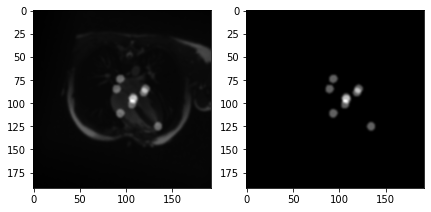

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 0.21484375
 0.23046875 0.234375   0.23828125 0.25390625 0.29296875 0.296875
 0.3125     0.33203125 0.34765625 0.36328125 0.41015625 0.4140625
 0.48828125 0.55078125 0.5546875  0.56640625 0.5703125  0.6328125
 0.6484375  0.6640625  0.6875     0.72265625 0.7421875  0.81640625
 0.8203125  0.8359375  0.85546875 0.859375   0.8984375  0.921875
 0.9375     0.94140625 0.96484375 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.23046875 0.234375
 0.23828125 0.296875   0.3125     0.33203125 0.41015625 0.50390625
 0.55078125 0.5703125  0.6640625  0.6875     0.7265625  0.81640625
 0.859375   0.91796875 0.921875   0.9375     0.98046875 0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.09765625 0.12109375 0.13671875 0.14453125 

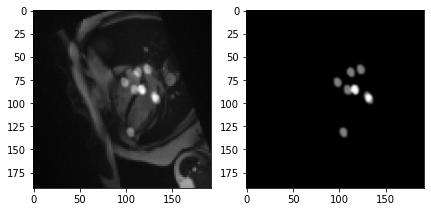

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.33203125 0.34765625
 0.4140625  0.546875   0.55078125 0.5546875  0.56640625 0.62890625
 0.6640625  0.6875     0.7421875  0.8203125  0.8359375  0.84375
 0.921875   0.9375     0.94140625 0.96484375 0.9765625  0.99609375
 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375  0.03515625
 0.04296875 0.0546875  0.05859375 0.0625     0.09765625 0.12109375
 0.13671875 0.14453125 0.15625    0.23046875 0.234375   0.23828125
 0.25390625 0.28125    0.296875   0.3125     0.33203125 0.34765625
 0.390625   0.41015625 0.453125   0.50390625 0.55078125 0.5546875
 0.56640625 0.5703125  0.62890625 0.640625   0.6640625  0.6875
 0.7265625  0.78125    0.8203125  0.8359375  0.83984375 0.859375
 0.90625    0.91796875 0.921875   0.9375     0.9609375  0.96484375
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00

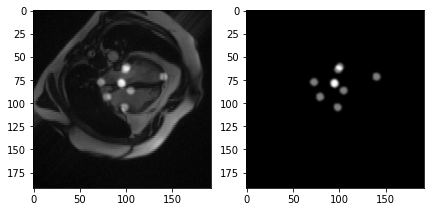

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.12109375 0.13671875 0.14453125
 0.21484375 0.21875    0.23046875 0.234375   0.25390625 0.28125
 0.296875   0.3125     0.33203125 0.34765625 0.36328125 0.4140625
 0.53125    0.546875   0.55078125 0.5546875  0.56640625 0.5703125
 0.6328125  0.640625   0.6640625  0.6875     0.7421875  0.8203125
 0.82421875 0.8359375  0.84375    0.85546875 0.859375   0.90625
 0.921875   0.9375     0.94140625 0.9609375  0.96484375 0.9765625
 0.98046875 0.9921875  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.05859375
 0.0625     0.12109375 0.13671875 0.14453125 0.23046875 0.234375
 0.25390625 0.296875   0.3125     0.33203125 0.34765625 0.36328125
 0.4140625  0.55078125 0.5546875  0.56640625 0.5703125  0.62890625
 0.6328125  0.6640625  0.6875     0.7421875  0.8203125  0.8359375
 0.83984375 0.85546875 0.859375   0.921875   0.9375     0.94140625
 0.96484375 0.98046875 0.9960

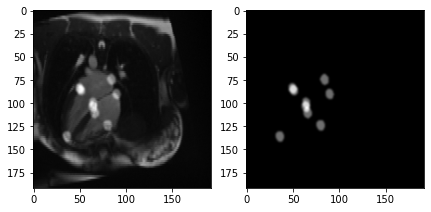

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.34765625 0.4140625
 0.546875   0.5546875  0.5703125  0.62890625 0.6640625  0.6875
 0.7421875  0.8359375  0.83984375 0.84375    0.921875   0.9375
 0.94140625 0.96484375 0.9765625  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.21875
 0.23046875 0.25390625 0.296875   0.3125     0.34765625 0.4140625
 0.546875   0.5546875  0.5703125  0.62890625 0.6640625  0.6875
 0.7421875  0.8359375  0.83984375 0.84375    0.921875   0.9375
 0.94140625 0.96484375 0.9765625  0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.07421875 0.12109375 0.13671875 0.140625
 0.14453125 0.21875    0.23046875 0.234375   0.25390625 0.296875
 0.3125     0.3203125  0.33203125 0.3476562

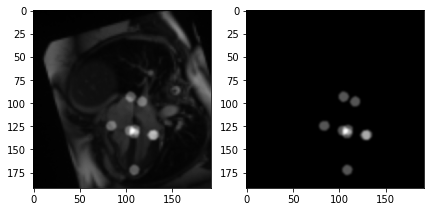

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.0546875  0.05859375 0.0625     0.07421875 0.12109375 0.13671875
 0.140625   0.14453125 0.21875    0.23046875 0.234375   0.25390625
 0.28125    0.296875   0.3125     0.3203125  0.33203125 0.34765625
 0.4140625  0.4296875  0.546875   0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.640625   0.6640625  0.6796875  0.6875
 0.7421875  0.765625   0.8203125  0.8359375  0.83984375 0.84375
 0.859375   0.90625    0.921875   0.92578125 0.9375     0.94140625
 0.95703125 0.96484375 0.9765625  0.98046875 0.9921875  0.99609375
 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.34765625
 0.4140625  0.5546875  0.5703125  0.62890625 0.640625   0.6640625
 0.6875     0.7421875  0.8359375  0.83984375 0.859375   0.90625
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.992

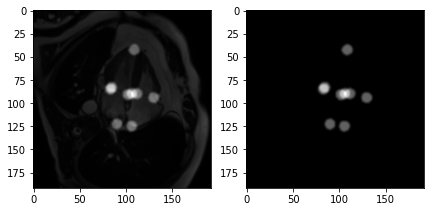

[0.         0.00390625 0.01953125 0.03515625 0.04296875 0.0546875
 0.05859375 0.0625     0.12109375 0.13671875 0.14453125 0.23046875
 0.234375   0.25390625 0.28125    0.296875   0.3125     0.33203125
 0.34765625 0.36328125 0.4140625  0.55078125 0.5546875  0.56640625
 0.5703125  0.62890625 0.6328125  0.640625   0.6640625  0.6875
 0.7421875  0.8203125  0.8359375  0.85546875 0.859375   0.90625
 0.921875   0.9375     0.94140625 0.96484375 0.98046875 0.9921875
 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.14453125
 0.21484375 0.21875    0.23046875 0.234375   0.23828125 0.25390625
 0.296875   0.3125     0.33203125 0.34765625 0.36328125 0.41015625
 0.4140625  0.50390625 0.53125    0.546875   0.55078125 0.5546875
 0.56640625 0.5703125  0.6328125  0.6640625  0.6875     0.7265625
 0.7421875  0.81640625 0.8203125  0.8359375  0.84375    0.85546875
 0.859375   0.91796875 0.921875   0.9375     0.94

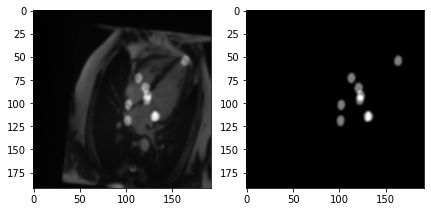

[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.21484375
 0.21875    0.23046875 0.234375   0.23828125 0.25390625 0.29296875
 0.296875   0.3125     0.33203125 0.41015625 0.4140625  0.48828125
 0.546875   0.55078125 0.56640625 0.5703125  0.6484375  0.6640625
 0.6875     0.72265625 0.7421875  0.81640625 0.8203125  0.84375
 0.859375   0.8984375  0.921875   0.9375     0.94140625 0.9765625
 0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.01953125 0.03515625 0.0390625  0.04296875
 0.05859375 0.0625     0.09765625 0.12109375 0.13671875 0.21875
 0.23046875 0.234375   0.23828125 0.25390625 0.296875   0.3125
 0.33203125 0.41015625 0.4140625  0.50390625 0.546875   0.55078125
 0.56640625 0.5703125  0.6640625  0.6875     0.7265625  0.7421875
 0.8203125  0.84375    0.859375   0.91796875 0.921875   0.9375
 0.94140625 0.9765625  0.98046875 0.99609375 1.        ]
[0.         0.00390625 0.015625   0.01953125 0.0234375

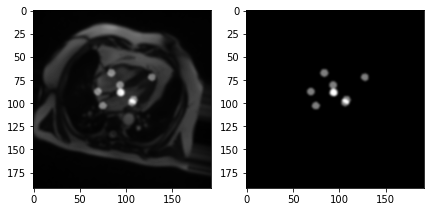

In [35]:
for _ in range(10):
    img_batch, poly_batch = gen._unaugmented_batch()
    img_batch, poly_batch = aug(images=img_batch, polygons=poly_batch)

    for img, poly in zip(img_batch, poly_batch):
        h, w = img.shape
        mask = np.zeros((h, w, 9))
        for k in range(len(poly)):
            mask[:,:,k] = CATCH_utils.to_mask(poly[k].to_shapely_polygon(), h, w)
            mask[:,:,k] = cv2.GaussianBlur(mask[:,:,k],(5,5),cv2.BORDER_CONSTANT)
        fig, axes = plt.subplots(1,2,figsize=(7,17))
        axes[0].imshow(img + np.sum(mask, axis=-1)*5, cmap='gray')
        axes[1].imshow(np.sum(mask, axis=-1), cmap='gray')
        plt.show()



In [ ]:
for img_batch, mask_batch in gen._multiprocessing_augmented_batches():
    for i in range(len(img_batch)):
        img, mask = img_batch[i], mask_batch[i]
        fig, ax = plt.subplots(1,1,figsize=(6,6))
        ax.imshow(img + np.sum(mask, axis=-1)*1.5, cmap='gray')
        plt.show()

In [ ]:
for _ in range(1):
    import time
    unaug  = gen._unaugmented_batch_generator()
    batch  = next(unaug)
    imgs1  = batch.images_unaug
    polys1 = batch.polygons_unaug

    time_start = time.time()
    #batches_aug = list(aug.augment_batches(batch, background=False))  # list() converts generator to list
    print(dir(batch))
    batches_aug = batch
    time_end = time.time()
    print("Augmentation done in %.2fs" % (time_end - time_start,))

    #imgs  = batches_aug[0].images_aug
    #polys = batches_aug[0].polygons_aug
    imgs  = batches_aug.images_unaug
    polys = batches_aug.polygons_unaug

    for i in range(batch_size):
        img, poly = imgs[i], polys[i]
        fig, ax = plt.subplots(1,1)
        ax.imshow(img); ax.axis('off')
        print(len(poly))
        print([p.label for p in poly])
        for p in poly:
            print(len(p.exterior))
            p   = np.concatenate((p.exterior, [p.exterior[0]]))
            x,y = zip(*p)
            ax.plot(x,y)
        plt.show()


In [ ]:
for _ in range(1):
    import time
    unaug  = gen._unaugmented_batch_generator()
    batch  = next(unaug)
    imgs1  = batch.images_unaug
    polys1 = batch.polygons_unaug

    time_start = time.time()
    batches_aug = list(aug.augment_batches(batch, background=False))  # list() converts generator to list
    time_end = time.time()
    print("Augmentation done in %.2fs" % (time_end - time_start,))

    imgs  = batches_aug[0].images_aug
    polys = batches_aug[0].polygons_aug

    for i in range(batch_size):
        img, poly = imgs[i], polys[i]
        h, w = img.shape
        mask = np.zeros((h, w, 5))
        for j in range(len(poly)): mask[:,:,j] = to_mask(poly[j].to_shapely_polygon(), h, w)
            
        fig, axes = plt.subplots(1,2, figsize=(25,15))
        for j in range(2): axes[j].imshow(img, cmap='gray'); axes[j].axis('off')
        
        #['lv_lax_endo', 'lv_lax_epi', 'rv_lax_endo', 'ra', 'la']
        mask_sum = np.sum(mask, axis=-1)
        axes[1].imshow(img + mask_sum*5, cmap='gray')
        #axes[1].imshow(img + mask[:,:,0]*3 + mask[:,:,1]*3, cmap='gray')
        
        
        plt.show()



In [ ]:
for img_batch, mask_batch in gen._multiprocessing_augmented_batches():
    for i in range(len(img_batch)):
        img, mask = img_batch[i], mask_batch[i]
        print(np.mean(img), np.mean(mask))
        plt.imshow(img + 5*np.sum(mask, axis=-1), cmap='gray')
        plt.show()
        



In [ ]:
import imgaug as ia
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage

for case in cases:
    print(case.case_name, case.reader_name)
    cat1  = [c for c in case.categories if c.name=='LAX 4CV LVES'][0]
    cat2  = [c for c in case.categories if c.name=='LAX 4CV LVED'][0]
    for cat in [cat1, cat2]:
        img   = cat.get_img (0, cat.phase).astype(np.float32)
        h, w  = img.shape
        anno  = cat.get_anno(0, cat.phase)
        ps1   = list(anno.get_point('lv_lax_extent').geoms)     if anno.has_point('lv_lax_extent')     else None
        ps2   = list(anno.get_point('laxRaExtentPoints').geoms) if anno.has_point('laxRaExtentPoints') else None
        ps3   = list(anno.get_point('laxLaExtentPoints').geoms) if anno.has_point('laxLaExtentPoints') else None
        print(ps1); print(ps2); print(ps3)
        try:                   ps = ps1 + ps2 + ps3
        except Exception as e: print(e)

        kps = [Keypoint(x=int(p.x), y=int(p.y)) for p in ps]

        fig, axes = plt.subplots(1,2,figsize=(10,6))
        axes[0].imshow(img, cmap='gray')
        xs, ys = [point.x for point in ps], [point.y for point in ps]
        axes[0].scatter(xs, ys, c='r',s=15,marker='x')
        plt.show()
        
        kpsoi = KeypointsOnImage(kps, shape=img.shape)

        img_aug, kpsoi_aug = aug(image=img, keypoints=kpsoi)
        ps_aug = [(kp.x,kp.y) for kp in kpsoi_aug]
        #ia.imshow(kpsoi_aug.draw_on_image(img_aug, color=4, size=3))

        print(kpsoi_aug[0].x, kpsoi_aug[0].y)
        ps_aug = [Point(p.x,p.y) for p in kpsoi_aug]
        print(ps_aug[0].x, ps_aug[0].y)